<a href="https://colab.research.google.com/github/JeanAdoudou/PaPiRus/blob/master/Bienvenue_dans_Colaboratory%20modif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-4-9c5981b727f1>:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Duree_minutes"].fillna(0, inplace=True)


📊 Total des validations réelles le 30 septembre : 214,658
🔮 Total des validations prédites (sans interruptions) : 247,239
📉 Différence entre prévision et réalité : 32,581 validations


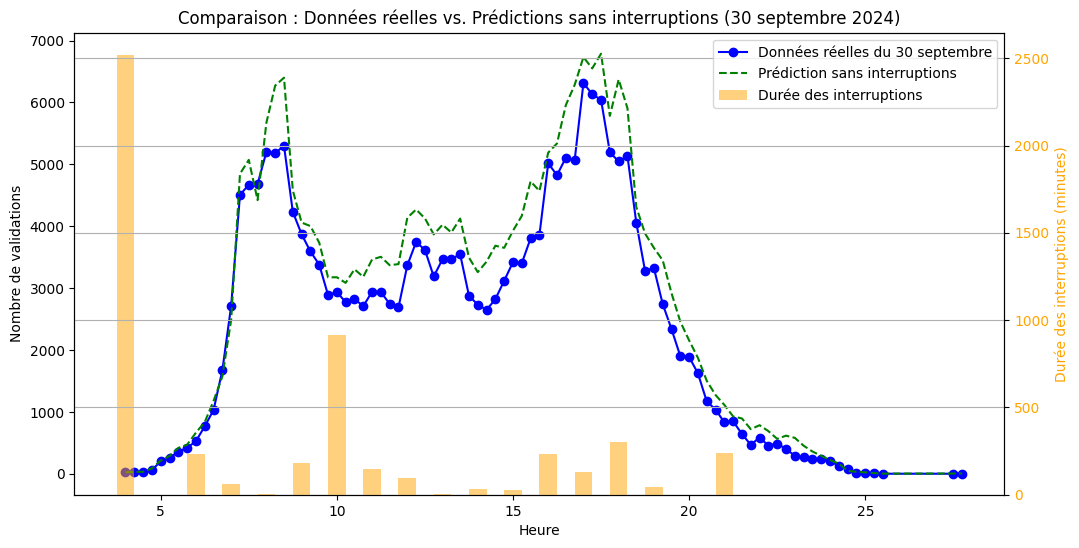

In [4]:
# 📌 Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# === 📂 CHARGEMENT DES DONNÉES ===
# 📌 Définition des fichiers
frequentation_file = "/content/drive/MyDrive/analyse_od_tram_bordeaux_septembre_2024.csv"
interruptions_file = "/content/drive/MyDrive/EVEX BRUT TRAM SEPTEMBRE 2024.xlsx"

# 🚀 Chargement des validations
frequentation_data = pd.read_csv(frequentation_file, sep=",", parse_dates=["date_exploitation"])

# 📅 Conversion en heures et minutes (tranches de 15 min)
frequentation_data["hour"] = (frequentation_data["timeslot"] * 60 // 60).astype(int)
frequentation_data["minute"] = ((frequentation_data["timeslot"] * 60) % 60 // 15) * 15
frequentation_data["date"] = frequentation_data["date_exploitation"].dt.date

# 📊 Agrégation des validations par tranche de 15 minutes
validations_agg = frequentation_data.groupby(["date", "hour", "minute"])["vvalidations"].sum().reset_index()

# 🚀 Chargement des interruptions
xls = pd.ExcelFile(interruptions_file)
interruptions_data = pd.read_excel(xls, sheet_name="AutresEvts", usecols=["DATE DEBUT", "DE", "DUREE"])
interruptions_data["DATE DEBUT"] = pd.to_datetime(interruptions_data["DATE DEBUT"], errors="coerce")

# 🔄 Correction des heures "25:30"
def correct_hour(date, hour_str):
    hour, minute = map(int, hour_str.split(":"))
    if hour >= 24:
        date = date + pd.Timedelta(days=1)
        hour -= 24
    return date.replace(hour=hour, minute=minute)

interruptions_data["DATE_HEURE_CORRIGEE"] = interruptions_data.apply(lambda row: correct_hour(row["DATE DEBUT"], row["DE"]), axis=1)

# ⏳ Conversion de la durée en minutes
interruptions_data["DUREE"] = interruptions_data["DUREE"].astype(str)
interruptions_data[["Heures", "Minutes"]] = interruptions_data["DUREE"].str.extract(r"(\d+):(\d+)").astype(float)
interruptions_data["Duree_minutes"] = interruptions_data["Heures"] * 60 + interruptions_data["Minutes"]
interruptions_data.drop(columns=["Heures", "Minutes"], inplace=True)

# 📊 Agréger interruptions par créneau de 15 minutes
interruptions_data["hour"] = interruptions_data["DATE_HEURE_CORRIGEE"].dt.hour
interruptions_data["minute"] = (interruptions_data["DATE_HEURE_CORRIGEE"].dt.minute // 15) * 15
interruptions_data["date"] = interruptions_data["DATE_HEURE_CORRIGEE"].dt.date
interruptions_agg = interruptions_data.groupby(["date", "hour", "minute"])["Duree_minutes"].sum().reset_index()

# 📊 Fusion interruptions + validations
data = pd.merge(validations_agg, interruptions_agg, on=["date", "hour", "minute"], how="left")
data["Duree_minutes"].fillna(0, inplace=True)

# 📅 Ajout du jour de la semaine
data["day_of_week"] = pd.to_datetime(data["date"]).dt.dayofweek

# === 🎯 MODÉLISATION & PRÉDICTION ===
# 📌 Sélection des variables
X = data[["hour", "minute", "Duree_minutes", "day_of_week"]]
y = data["vvalidations"]

# 📅 Séparer les données : entraînement sur **1-29 septembre**, test sur le **30 septembre**
train_data = data[data["date"] < pd.to_datetime("2024-09-30").date()]
test_data = data[data["date"] == pd.to_datetime("2024-09-30").date()]

X_train = train_data[["hour", "minute", "Duree_minutes", "day_of_week"]]
y_train = train_data["vvalidations"]

# 🌲 Entraînement du modèle Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 🔮 Prédiction pour le **30 septembre 2024** (sans interruptions)
prediction_data_no_inc = test_data.copy()
prediction_data_no_inc["Duree_minutes"] = 0  # Suppression des interruptions
prediction_data_no_inc["Predicted Validations"] = model.predict(prediction_data_no_inc[["hour", "minute", "Duree_minutes", "day_of_week"]])

# 📊 Agrégation des interruptions par heure
interruptions_hourly = interruptions_data[interruptions_data["date"] == pd.to_datetime("2024-09-30").date()]
interruptions_hourly = interruptions_hourly.groupby("hour")["Duree_minutes"].sum().reset_index()

# 📊 Calcul du total des validations
total_validations_reelles = test_data["vvalidations"].sum()
total_validations_predites = prediction_data_no_inc["Predicted Validations"].sum()
difference = total_validations_predites - total_validations_reelles

# ✅ Affichage des résultats
print(f"📊 Total des validations réelles le 30 septembre : {total_validations_reelles:,.0f}")
print(f"🔮 Total des validations prédites (sans interruptions) : {total_validations_predites:,.0f}")
print(f"📉 Différence entre prévision et réalité : {difference:,.0f} validations")

# === 📊 AFFICHAGE DU GRAPHIQUE FINAL ===
fig, ax1 = plt.subplots(figsize=(12, 6))

# 🔵 Courbe des **données réelles du 30 septembre**
ax1.plot(
    test_data["hour"] + test_data["minute"] / 60,
    test_data["vvalidations"], "bo-", label="Données réelles du 30 septembre"
)

# 🟢 Courbe des **prédictions sans interruptions**
ax1.plot(
    prediction_data_no_inc["hour"] + prediction_data_no_inc["minute"] / 60,
    prediction_data_no_inc["Predicted Validations"], "g--", label="Prédiction sans interruptions"
)

ax1.set_xlabel("Heure")
ax1.set_ylabel("Nombre de validations", color="black")
ax1.tick_params(axis="y", labelcolor="black")

# 📊 Ajout des interruptions sur une **seconde échelle (axe droit)**
ax2 = ax1.twinx()
ax2.bar(
    interruptions_hourly["hour"],
    interruptions_hourly["Duree_minutes"], width=0.5, color="orange", alpha=0.5, label="Durée des interruptions"
)
ax2.set_ylabel("Durée des interruptions (minutes)", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

# 🏷️ Ajout des légendes
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.title("Comparaison : Données réelles vs. Prédictions sans interruptions (30 septembre 2024)")
plt.grid()
plt.show()


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


📌 Feuilles disponibles : ['Feuil1']
📌 Colonnes disponibles dans le fichier arrêts : Index([                     'Jour',                     'Heure',
                   'Arrêts prévus',           'Arrêts réalisés',
       '% écart réalisés / prévus',                           1],
      dtype='object')


<ipython-input-3-86453fae7b9c>:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Duree_minutes"].fillna(0, inplace=True)


📊 Total des validations réelles le 30 septembre : 214,658
🔮 Total des validations prédites (sans interruptions) : 244,973
📉 Différence entre prévision et réalité : 30,315 validations


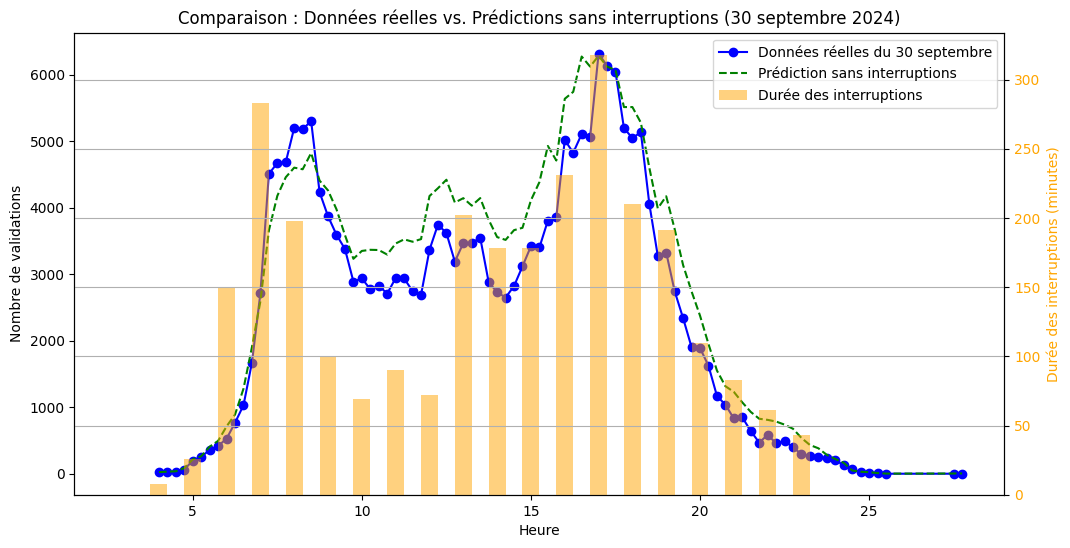

In [3]:
# 📌 Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# === 📂 CHARGEMENT DES DONNÉES ===
# 📌 Définition des fichiers
frequentation_file = "/content/drive/MyDrive/analyse_od_tram_bordeaux_septembre_2024.csv"
arrets_file = "/content/drive/MyDrive/Arrets réalisés vs arrets prévus sept 2024.xlsx"

# 🚀 Chargement des validations
frequentation_data = pd.read_csv(frequentation_file, sep=",", parse_dates=["date_exploitation"])

# 📅 Conversion en heures et minutes (tranches de 15 min)
frequentation_data["hour"] = (frequentation_data["timeslot"] * 60 // 60).astype(int)
frequentation_data["minute"] = ((frequentation_data["timeslot"] * 60) % 60 // 15) * 15
frequentation_data["date"] = frequentation_data["date_exploitation"].dt.date

# 📊 Agrégation des validations par tranche de 15 minutes
validations_agg = frequentation_data.groupby(["date", "hour", "minute"])["vvalidations"].sum().reset_index()

# 🚀 Chargement des arrêts prévus vs réalisés
xls = pd.ExcelFile(arrets_file)

# 🔍 Vérification des noms de feuilles
print("📌 Feuilles disponibles :", xls.sheet_names)

# 📂 Lecture du fichier (remplacer 'Feuil1' par la bonne feuille si nécessaire)
arrets_data = pd.read_excel(xls, sheet_name="Feuil1")

# 🔍 Vérification des colonnes
print("📌 Colonnes disponibles dans le fichier arrêts :", arrets_data.columns)

# 🏷️ Renommer les colonnes pour plus de clarté
arrets_data.rename(columns={
    "Jour": "date",
    "Heure": "hour",
    "Arrêts prévus": "arrets_prevus",
    "Arrêts réalisés": "arrets_realises"
}, inplace=True)

# 📅 Conversion des dates au format correct
arrets_data["date"] = pd.to_datetime(arrets_data["date"], errors='coerce').dt.date

# 🔢 Conversion des valeurs en nombres (éviter les erreurs de type)
arrets_data["arrets_prevus"] = pd.to_numeric(arrets_data["arrets_prevus"], errors="coerce")
arrets_data["arrets_realises"] = pd.to_numeric(arrets_data["arrets_realises"], errors="coerce")

# 📉 Calcul des interruptions comme écart entre arrêts prévus et réalisés
arrets_data["Duree_minutes"] = (arrets_data["arrets_prevus"] - arrets_data["arrets_realises"]).clip(lower=0)

# 📊 Agrégation des interruptions par créneau de 15 minutes
interruptions_agg = arrets_data.groupby(["date", "hour"])["Duree_minutes"].sum().reset_index()

# 📊 Fusion interruptions + validations
data = pd.merge(validations_agg, interruptions_agg, on=["date", "hour"], how="left")
data["Duree_minutes"].fillna(0, inplace=True)

# 📅 Ajout du jour de la semaine
data["day_of_week"] = pd.to_datetime(data["date"]).dt.dayofweek

# === 🎯 MODÉLISATION & PRÉDICTION ===
# 📌 Sélection des variables
X = data[["hour", "minute", "Duree_minutes", "day_of_week"]]
y = data["vvalidations"]

# 📅 Séparer les données : entraînement sur **1-29 septembre**, test sur le **30 septembre**
train_data = data[data["date"] < pd.to_datetime("2024-09-30").date()]
test_data = data[data["date"] == pd.to_datetime("2024-09-30").date()]

X_train = train_data[["hour", "minute", "Duree_minutes", "day_of_week"]]
y_train = train_data["vvalidations"]

# 🌲 Entraînement du modèle Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 🔮 Prédiction pour le **30 septembre 2024** (sans interruptions)
prediction_data_no_inc = test_data.copy()
prediction_data_no_inc["Duree_minutes"] = 0  # Suppression des interruptions
prediction_data_no_inc["Predicted Validations"] = model.predict(prediction_data_no_inc[["hour", "minute", "Duree_minutes", "day_of_week"]])

# 📊 Agrégation des interruptions par heure
interruptions_hourly = arrets_data[arrets_data["date"] == pd.to_datetime("2024-09-30").date()]
interruptions_hourly = interruptions_hourly.groupby("hour")["Duree_minutes"].sum().reset_index()

# 📊 Calcul du total des validations
total_validations_reelles = test_data["vvalidations"].sum()
total_validations_predites = prediction_data_no_inc["Predicted Validations"].sum()
difference = total_validations_predites - total_validations_reelles

# ✅ Affichage des résultats
print(f"📊 Total des validations réelles le 30 septembre : {total_validations_reelles:,.0f}")
print(f"🔮 Total des validations prédites (sans interruptions) : {total_validations_predites:,.0f}")
print(f"📉 Différence entre prévision et réalité : {difference:,.0f} validations")

# === 📊 AFFICHAGE DU GRAPHIQUE FINAL ===
fig, ax1 = plt.subplots(figsize=(12, 6))

# 🔵 Courbe des **données réelles du 30 septembre**
ax1.plot(
    test_data["hour"] + test_data["minute"] / 60,
    test_data["vvalidations"], "bo-", label="Données réelles du 30 septembre"
)

# 🟢 Courbe des **prédictions sans interruptions**
ax1.plot(
    prediction_data_no_inc["hour"] + prediction_data_no_inc["minute"] / 60,
    prediction_data_no_inc["Predicted Validations"], "g--", label="Prédiction sans interruptions"
)

ax1.set_xlabel("Heure")
ax1.set_ylabel("Nombre de validations", color="black")
ax1.tick_params(axis="y", labelcolor="black")

# 📊 Ajout des interruptions sur une **seconde échelle (axe droit)**
ax2 = ax1.twinx()
ax2.bar(
    interruptions_hourly["hour"],
    interruptions_hourly["Duree_minutes"], width=0.5, color="orange", alpha=0.5, label="Durée des interruptions"
)
ax2.set_ylabel("Durée des interruptions (minutes)", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

# 🏷️ Ajout des légendes
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.title("Comparaison : Données réelles vs. Prédictions sans interruptions (30 septembre 2024)")
plt.grid()
plt.show()


📌 Colonnes disponibles dans le fichier arrêts : Index([                     'Jour',                     'Heure',
                   'Arrêts prévus',           'Arrêts réalisés',
       '% écart réalisés / prévus',                           1],
      dtype='object')


<ipython-input-19-0acd416b6551>:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Arrets_perdus"].fillna(0, inplace=True)


📊 Total des validations réelles le 30 septembre : 214,658
🔮 Total des validations prédites (sans interruptions) : 251,689
📉 Différence entre prévision et réalité : 37,031 validations


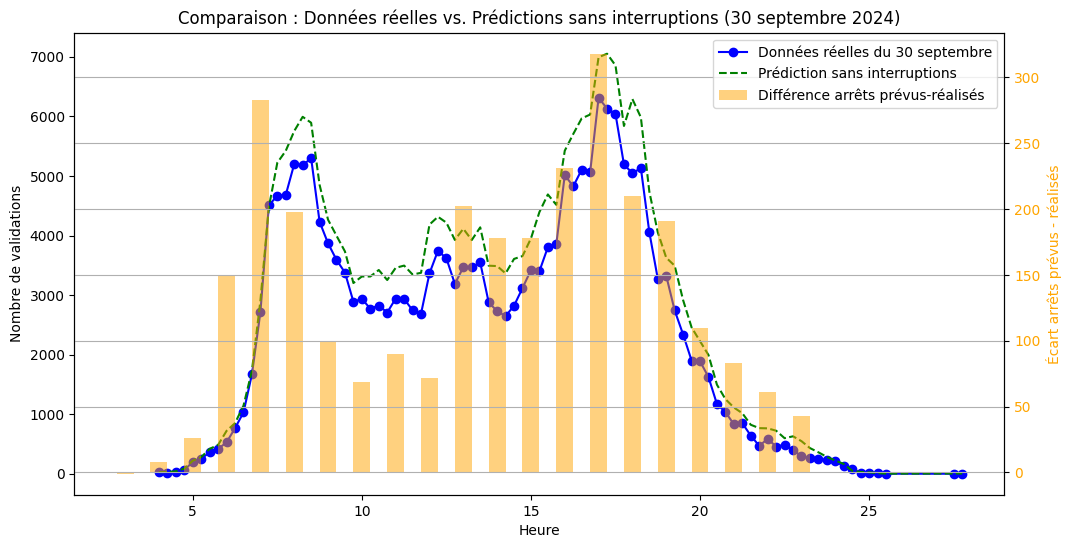

In [19]:
# 📌 Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# === 📂 CHARGEMENT DES DONNÉES ===
# 📌 Définition des fichiers
frequentation_file = "/content/drive/MyDrive/analyse_od_tram_bordeaux_septembre_2024.csv"
arrets_file = "/content/drive/MyDrive/Arrets réalisés vs arrets prévus sept 2024.xlsx"

# 🚀 Chargement des validations
frequentation_data = pd.read_csv(frequentation_file, sep=",", parse_dates=["date_exploitation"])

# 📅 Conversion en heures et minutes (tranches de 15 min)
frequentation_data["hour"] = (frequentation_data["timeslot"] * 60 // 60).astype(int)
frequentation_data["minute"] = ((frequentation_data["timeslot"] * 60) % 60 // 15) * 15
frequentation_data["date"] = frequentation_data["date_exploitation"].dt.date

# 📊 Agrégation des validations par tranche de 15 minutes
validations_agg = frequentation_data.groupby(["date", "hour", "minute"])["vvalidations"].sum().reset_index()

# 🚀 Chargement des arrêts prévus vs réalisés
xls = pd.ExcelFile(arrets_file)
arrets_data = pd.read_excel(xls, sheet_name="Feuil1")

# 📌 Vérification des colonnes disponibles
print("📌 Colonnes disponibles dans le fichier arrêts :", arrets_data.columns)

# 📅 Conversion des dates
arrets_data["Jour"] = pd.to_datetime(arrets_data["Jour"], errors="coerce").dt.date

# 📌 Conversion des colonnes "Arrêts prévus" et "Arrêts réalisés" en nombres
arrets_data["Arrêts prévus"] = pd.to_numeric(arrets_data["Arrêts prévus"], errors="coerce")
arrets_data["Arrêts réalisés"] = pd.to_numeric(arrets_data["Arrêts réalisés"], errors="coerce")

# 📉 Calcul des interruptions comme écart entre arrêts prévus et réalisés
arrets_data["Arrets_perdus"] = arrets_data["Arrêts prévus"] - arrets_data["Arrêts réalisés"]

# 📊 Agréger interruptions par créneau de 15 minutes
arrets_data.rename(columns={"Jour": "date", "Heure": "hour"}, inplace=True)
arrets_data["minute"] = (arrets_data["hour"].astype(int) % 60 // 15) * 15
arrets_agg = arrets_data.groupby(["date", "hour", "minute"])["Arrets_perdus"].sum().reset_index()

# 📊 Fusion interruptions (écart d'arrêts) + validations
data = pd.merge(validations_agg, arrets_agg, on=["date", "hour", "minute"], how="left")
data["Arrets_perdus"].fillna(0, inplace=True)

# 📅 Ajout du jour de la semaine
data["day_of_week"] = pd.to_datetime(data["date"]).dt.dayofweek

# === 🎯 MODÉLISATION & PRÉDICTION ===
# 📌 Sélection des variables
X = data[["hour", "minute", "Arrets_perdus", "day_of_week"]]
y = data["vvalidations"]

# 📅 Séparer les données : entraînement sur **1-29 septembre**, test sur le **30 septembre**
train_data = data[data["date"] < pd.to_datetime("2024-09-30").date()]
test_data = data[data["date"] == pd.to_datetime("2024-09-30").date()]

X_train = train_data[["hour", "minute", "Arrets_perdus", "day_of_week"]]
y_train = train_data["vvalidations"]

# 🌲 Entraînement du modèle Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 🔮 Prédiction pour le **30 septembre 2024** (sans interruptions)
prediction_data_no_inc = test_data.copy()
prediction_data_no_inc["Arrets_perdus"] = 0  # Suppression des interruptions
prediction_data_no_inc["Predicted Validations"] = model.predict(prediction_data_no_inc[["hour", "minute", "Arrets_perdus", "day_of_week"]])

# 📊 Agrégation des arrêts perdus par heure
arrets_hourly = arrets_data[arrets_data["date"] == pd.to_datetime("2024-09-30").date()]
arrets_hourly = arrets_hourly.groupby("hour")["Arrets_perdus"].sum().reset_index()

# 📊 Calcul du total des validations
total_validations_reelles = test_data["vvalidations"].sum()
total_validations_predites = prediction_data_no_inc["Predicted Validations"].sum()
difference = total_validations_predites - total_validations_reelles

# ✅ Affichage des résultats
print(f"📊 Total des validations réelles le 30 septembre : {total_validations_reelles:,.0f}")
print(f"🔮 Total des validations prédites (sans interruptions) : {total_validations_predites:,.0f}")
print(f"📉 Différence entre prévision et réalité : {difference:,.0f} validations")

# === 📊 AFFICHAGE DU GRAPHIQUE FINAL ===
fig, ax1 = plt.subplots(figsize=(12, 6))

# 🔵 Courbe des **données réelles du 30 septembre**
ax1.plot(
    test_data["hour"] + test_data["minute"] / 60,
    test_data["vvalidations"], "bo-", label="Données réelles du 30 septembre"
)

# 🟢 Courbe des **prédictions sans interruptions**
ax1.plot(
    prediction_data_no_inc["hour"] + prediction_data_no_inc["minute"] / 60,
    prediction_data_no_inc["Predicted Validations"], "g--", label="Prédiction sans interruptions"
)

ax1.set_xlabel("Heure")
ax1.set_ylabel("Nombre de validations", color="black")
ax1.tick_params(axis="y", labelcolor="black")

# 📊 Ajout de la différence entre arrêts prévus et réalisés sur une **seconde échelle (axe droit)**
ax2 = ax1.twinx()
ax2.bar(
    arrets_hourly["hour"],
    arrets_hourly["Arrets_perdus"], width=0.5, color="orange", alpha=0.5, label="Différence arrêts prévus-réalisés"
)
ax2.set_ylabel("Écart arrêts prévus - réalisés", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

# 🏷️ Ajout des légendes
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.title("Comparaison : Données réelles vs. Prédictions sans interruptions (30 septembre 2024)")
plt.grid()
plt.show()


<ipython-input-10-317e07a8f1bf>:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Arrets_perdus"].fillna(0, inplace=True)


📊 Total des validations réelles le 30 septembre : 214,658
🌲 Random Forest : 250,413 (Différence : 35,755)
⚡ XGBoost : 252,432 (Différence : 37,774)


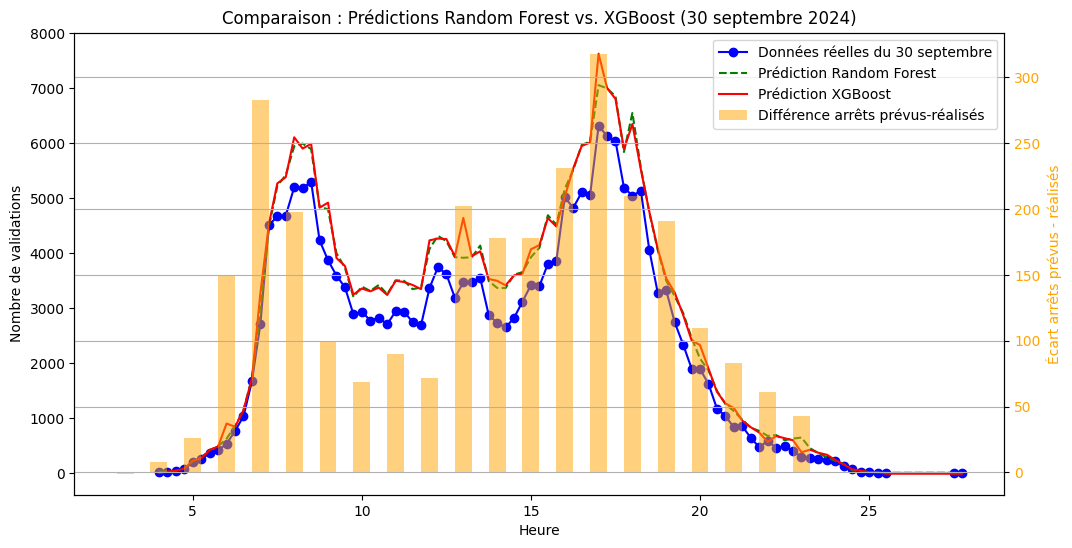

In [10]:
# 📌 Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# === 📂 CHARGEMENT DES DONNÉES ===
# 📌 Définition des fichiers
frequentation_file = "/content/drive/MyDrive/analyse_od_tram_bordeaux_septembre_2024.csv"
arrets_file = "/content/drive/MyDrive/Arrets réalisés vs arrets prévus sept 2024.xlsx"

# 🚀 Chargement des validations
frequentation_data = pd.read_csv(frequentation_file, sep=",", parse_dates=["date_exploitation"])
frequentation_data["hour"] = (frequentation_data["timeslot"] * 60 // 60).astype(int)
frequentation_data["minute"] = ((frequentation_data["timeslot"] * 60) % 60 // 15) * 15
frequentation_data["date"] = frequentation_data["date_exploitation"].dt.date
validations_agg = frequentation_data.groupby(["date", "hour", "minute"])["vvalidations"].sum().reset_index()

# 🚀 Chargement des arrêts prévus vs réalisés
xls = pd.ExcelFile(arrets_file)
arrets_data = pd.read_excel(xls, sheet_name="Feuil1")

# 📌 Nettoyage et conversion des données
arrets_data.rename(columns={"Jour": "date", "Heure": "hour", "Arrêts prévus": "Arrets_prevus",
                            "Arrêts réalisés": "Arrets_realises"}, inplace=True)
arrets_data["date"] = pd.to_datetime(arrets_data["date"], format="%d/%m/%Y").dt.date
arrets_data["hour"] = arrets_data["hour"].astype(int)
arrets_data["Arrets_prevus"] = pd.to_numeric(arrets_data["Arrets_prevus"], errors='coerce').fillna(0).astype(int)
arrets_data["Arrets_realises"] = pd.to_numeric(arrets_data["Arrets_realises"], errors='coerce').fillna(0).astype(int)
arrets_data["Arrets_perdus"] = arrets_data["Arrets_prevus"] - arrets_data["Arrets_realises"]
arrets_data["minute"] = 0  # On suppose des données par heure
arrets_agg = arrets_data.groupby(["date", "hour", "minute"])["Arrets_perdus"].sum().reset_index()

# 📊 Fusion interruptions + validations
data = pd.merge(validations_agg, arrets_agg, on=["date", "hour", "minute"], how="left")
data["Arrets_perdus"].fillna(0, inplace=True)
data["day_of_week"] = pd.to_datetime(data["date"]).dt.dayofweek

# === 🎯 MODÉLISATION & PRÉDICTION ===
# 📌 Séparation entraînement/test
train_data = data[data["date"] < pd.to_datetime("2024-09-30").date()]
test_data = data[data["date"] == pd.to_datetime("2024-09-30").date()]

# 🔮 Entraînement et prédiction avec Random Forest
X_train = train_data[["hour", "minute", "Arrets_perdus", "day_of_week"]]
y_train = train_data["vvalidations"]
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

prediction_rf = test_data.copy()
prediction_rf["Predicted Validations"] = model_rf.predict(prediction_rf[["hour", "minute", "Arrets_perdus", "day_of_week"]])

# 🔮 Entraînement et prédiction avec XGBoost
model_xgb = XGBRegressor(n_estimators=100, random_state=42)
model_xgb.fit(X_train, y_train)

prediction_xgb = test_data.copy()
prediction_xgb["Predicted Validations"] = model_xgb.predict(prediction_xgb[["hour", "minute", "Arrets_perdus", "day_of_week"]])

# 📊 Agrégation des arrêts perdus par heure pour le 30 septembre uniquement
arrets_hourly = arrets_data[arrets_data["date"] == pd.to_datetime("2024-09-30").date()]
arrets_hourly = arrets_hourly.groupby("hour")["Arrets_perdus"].sum().reset_index()

# 📊 Calcul du total des validations pour comparaison
total_validations_reelles = test_data["vvalidations"].sum()
total_validations_rf = prediction_rf["Predicted Validations"].sum()
total_validations_xgb = prediction_xgb["Predicted Validations"].sum()

difference_rf = total_validations_rf - total_validations_reelles
difference_xgb = total_validations_xgb - total_validations_reelles

# ✅ Affichage des résultats
print(f"📊 Total des validations réelles le 30 septembre : {total_validations_reelles:,.0f}")
print(f"🌲 Random Forest : {total_validations_rf:,.0f} (Différence : {difference_rf:,.0f})")
print(f"⚡ XGBoost : {total_validations_xgb:,.0f} (Différence : {difference_xgb:,.0f})")

# === 📊 AFFICHAGE DU GRAPHIQUE FINAL ===
fig, ax1 = plt.subplots(figsize=(12, 6))

# 🔵 Courbe des **données réelles du 30 septembre**
ax1.plot(
    test_data["hour"] + test_data["minute"] / 60,
    test_data["vvalidations"], "bo-", label="Données réelles du 30 septembre"
)

# 🟢 Courbe des **prédictions Random Forest**
ax1.plot(
    prediction_rf["hour"] + prediction_rf["minute"] / 60,
    prediction_rf["Predicted Validations"], "g--", label="Prédiction Random Forest"
)

# 🔴 Courbe des **prédictions XGBoost**
ax1.plot(
    prediction_xgb["hour"] + prediction_xgb["minute"] / 60,
    prediction_xgb["Predicted Validations"], "r-", label="Prédiction XGBoost"
)

ax1.set_xlabel("Heure")
ax1.set_ylabel("Nombre de validations", color="black")
ax1.tick_params(axis="y", labelcolor="black")

# 📊 Ajout de la différence entre arrêts prévus et réalisés sur une **seconde échelle (axe droit)**
ax2 = ax1.twinx()
ax2.bar(
    arrets_hourly["hour"],
    arrets_hourly["Arrets_perdus"], width=0.5, color="orange", alpha=0.5, label="Différence arrêts prévus-réalisés"
)
ax2.set_ylabel("Écart arrêts prévus - réalisés", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

# 🏷️ Ajout des légendes
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.title("Comparaison : Prédictions Random Forest vs. XGBoost (30 septembre 2024)")
plt.grid()
plt.show()


<ipython-input-11-2175dadab741>:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Arrets_perdus"].fillna(0, inplace=True)
<ipython-input-11-2175dadab741>:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

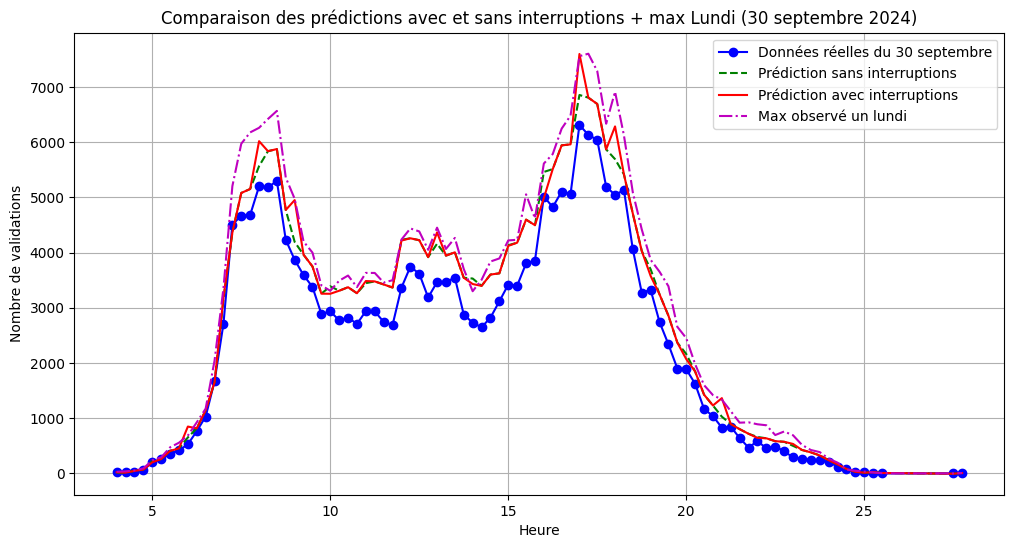

In [11]:
# 📌 Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# === 📂 CHARGEMENT DES DONNÉES ===
# 📌 Définition des fichiers
frequentation_file = "/content/drive/MyDrive/analyse_od_tram_bordeaux_septembre_2024.csv"
arrets_file = "/content/drive/MyDrive/Arrets réalisés vs arrets prévus sept 2024.xlsx"

# 🚀 Chargement des validations
frequentation_data = pd.read_csv(frequentation_file, sep=",", parse_dates=["date_exploitation"])
frequentation_data["hour"] = (frequentation_data["timeslot"] * 60 // 60).astype(int)
frequentation_data["minute"] = ((frequentation_data["timeslot"] * 60) % 60 // 15) * 15
frequentation_data["date"] = frequentation_data["date_exploitation"].dt.date
frequentation_data["day_of_week"] = pd.to_datetime(frequentation_data["date"]).dt.dayofweek

# 📊 Agrégation des validations par tranche de 15 minutes
validations_agg = frequentation_data.groupby(["date", "hour", "minute", "day_of_week"])["vvalidations"].sum().reset_index()

# 🚀 Chargement des arrêts prévus vs réalisés
xls = pd.ExcelFile(arrets_file)
arrets_data = pd.read_excel(xls, sheet_name="Feuil1")

# 🛠 Nettoyage et conversion des données
arrets_data.rename(columns={"Jour": "date", "Heure": "hour", "Arrêts prévus": "Arrets_prevus", "Arrêts réalisés": "Arrets_realises"}, inplace=True)
arrets_data["date"] = pd.to_datetime(arrets_data["date"], format="%d/%m/%Y").dt.date
arrets_data["hour"] = arrets_data["hour"].astype(int)
arrets_data["Arrets_prevus"] = pd.to_numeric(arrets_data["Arrets_prevus"], errors='coerce').fillna(0).astype(int)
arrets_data["Arrets_realises"] = pd.to_numeric(arrets_data["Arrets_realises"], errors='coerce').fillna(0).astype(int)
arrets_data["Arrets_perdus"] = arrets_data["Arrets_prevus"] - arrets_data["Arrets_realises"]
arrets_data["minute"] = 0  # On suppose des données par heure
arrets_agg = arrets_data.groupby(["date", "hour", "minute"])["Arrets_perdus"].sum().reset_index()

# 📊 Fusion interruptions + validations
data = pd.merge(validations_agg, arrets_agg, on=["date", "hour", "minute"], how="left")
data["Arrets_perdus"].fillna(0, inplace=True)

# 🌧 Ajout de la météo
dates_meteo = pd.to_datetime(["2024-09-01", "2024-09-02", "2024-09-03", "2024-09-04", "2024-09-05",
                              "2024-09-06", "2024-09-07", "2024-09-08", "2024-09-09", "2024-09-11",
                              "2024-09-13", "2024-09-15", "2024-09-21", "2024-09-22", "2024-09-23",
                              "2024-09-24", "2024-09-25", "2024-09-26", "2024-09-27", "2024-09-28",
                              "2024-09-29", "2024-09-30"]).date
precipitation = [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
meteo_data = pd.DataFrame({"date": dates_meteo, "precipitation": precipitation})
data = pd.merge(data, meteo_data, on="date", how="left")
data["precipitation"].fillna(0, inplace=True)

# === 🎯 MODÉLISATION & PRÉDICTION ===
# 📌 Séparation entraînement/test
train_data = data[data["date"] < pd.to_datetime("2024-09-30").date()]
test_data = data[data["date"] == pd.to_datetime("2024-09-30").date()]

# 🔮 Prédiction des arrêts perdus
X_arrets = train_data[["hour", "minute", "day_of_week", "precipitation"]]
y_arrets = train_data["Arrets_perdus"]
model_arrets = XGBRegressor(n_estimators=100, random_state=42)
model_arrets.fit(X_arrets, y_arrets)
test_data["Arrets_perdus_pred"] = model_arrets.predict(test_data[["hour", "minute", "day_of_week", "precipitation"]])

# 🔮 Prédiction de la fréquentation
X_train = train_data[["hour", "minute", "Arrets_perdus", "day_of_week", "precipitation"]]
y_train = train_data["vvalidations"]
model_frequentation = XGBRegressor(n_estimators=100, random_state=42)
model_frequentation.fit(X_train, y_train)

prediction_data_inc = test_data.copy()
prediction_data_inc["Predicted Validations"] = model_frequentation.predict(prediction_data_inc[["hour", "minute", "Arrets_perdus", "day_of_week", "precipitation"]])

prediction_data_no_inc = test_data.copy()
prediction_data_no_inc["Arrets_perdus"] = 0  # Suppression des interruptions
prediction_data_no_inc["Predicted Validations"] = model_frequentation.predict(prediction_data_no_inc[["hour", "minute", "Arrets_perdus", "day_of_week", "precipitation"]])

# 📊 Calcul du **maximum de validations pour un lundi**
max_validations_lundi = data[data["day_of_week"] == 0].groupby(["hour", "minute"])["vvalidations"].max().reset_index()

# 📊 AFFICHAGE DU GRAPHIQUE FINAL
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(test_data["hour"] + test_data["minute"] / 60, test_data["vvalidations"], "bo-", label="Données réelles du 30 septembre")
ax1.plot(prediction_data_no_inc["hour"] + prediction_data_no_inc["minute"] / 60, prediction_data_no_inc["Predicted Validations"], "g--", label="Prédiction sans interruptions")
ax1.plot(prediction_data_inc["hour"] + prediction_data_inc["minute"] / 60, prediction_data_inc["Predicted Validations"], "r-", label="Prédiction avec interruptions")
ax1.plot(max_validations_lundi["hour"] + max_validations_lundi["minute"] / 60, max_validations_lundi["vvalidations"], "m-.", label="Max observé un lundi")
ax1.set_xlabel("Heure")
ax1.set_ylabel("Nombre de validations")
ax1.legend()
plt.title("Comparaison des prédictions avec et sans interruptions + max Lundi (30 septembre 2024)")
plt.grid()
plt.show()


<ipython-input-12-7712718f9e14>:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Arrets_perdus"].fillna(0, inplace=True)


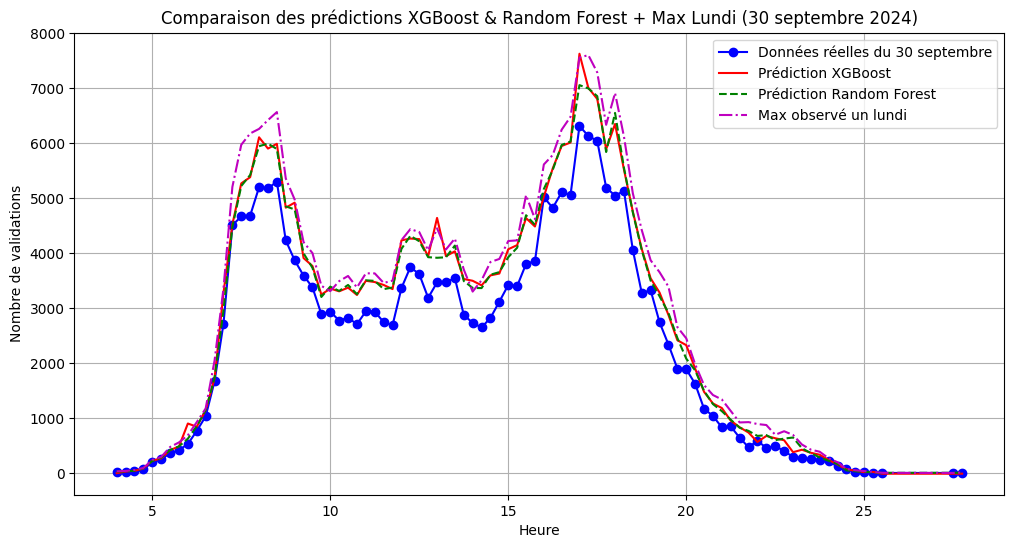

In [12]:
# 📌 Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# === 📂 CHARGEMENT DES DONNÉES ===
# 📌 Définition des fichiers
frequentation_file = "/content/drive/MyDrive/analyse_od_tram_bordeaux_septembre_2024.csv"
arrets_file = "/content/drive/MyDrive/Arrets réalisés vs arrets prévus sept 2024.xlsx"

# 🚀 Chargement des validations
frequentation_data = pd.read_csv(frequentation_file, sep=",", parse_dates=["date_exploitation"])
frequentation_data["hour"] = (frequentation_data["timeslot"] * 60 // 60).astype(int)
frequentation_data["minute"] = ((frequentation_data["timeslot"] * 60) % 60 // 15) * 15
frequentation_data["date"] = frequentation_data["date_exploitation"].dt.date
frequentation_data["day_of_week"] = pd.to_datetime(frequentation_data["date"]).dt.dayofweek

# 📊 Agrégation des validations par tranche de 15 minutes
validations_agg = frequentation_data.groupby(["date", "hour", "minute", "day_of_week"])["vvalidations"].sum().reset_index()

# 🚀 Chargement des arrêts prévus vs réalisés
xls = pd.ExcelFile(arrets_file)
arrets_data = pd.read_excel(xls, sheet_name="Feuil1")

# 🛠 Nettoyage et conversion des données
arrets_data.rename(columns={"Jour": "date", "Heure": "hour", "Arrêts prévus": "Arrets_prevus", "Arrêts réalisés": "Arrets_realises"}, inplace=True)
arrets_data["date"] = pd.to_datetime(arrets_data["date"], format="%d/%m/%Y").dt.date
arrets_data["hour"] = arrets_data["hour"].astype(int)
arrets_data["Arrets_prevus"] = pd.to_numeric(arrets_data["Arrets_prevus"], errors='coerce').fillna(0).astype(int)
arrets_data["Arrets_realises"] = pd.to_numeric(arrets_data["Arrets_realises"], errors='coerce').fillna(0).astype(int)
arrets_data["Arrets_perdus"] = arrets_data["Arrets_prevus"] - arrets_data["Arrets_realises"]
arrets_data["minute"] = 0  # On suppose des données par heure
arrets_agg = arrets_data.groupby(["date", "hour", "minute"])["Arrets_perdus"].sum().reset_index()

# 📊 Fusion interruptions + validations
data = pd.merge(validations_agg, arrets_agg, on=["date", "hour", "minute"], how="left")
data["Arrets_perdus"].fillna(0, inplace=True)

# === 🎯 MODÉLISATION & PRÉDICTION ===
# 📌 Séparation entraînement/test
train_data = data[data["date"] < pd.to_datetime("2024-09-30").date()]
test_data = data[data["date"] == pd.to_datetime("2024-09-30").date()]

# 🔮 Prédiction de la fréquentation avec **XGBoost**
X_train = train_data[["hour", "minute", "Arrets_perdus", "day_of_week"]]
y_train = train_data["vvalidations"]
model_xgb = XGBRegressor(n_estimators=100, random_state=42)
model_xgb.fit(X_train, y_train)

# 🔮 Prédiction de la fréquentation avec **Random Forest**
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# 📊 Création des données de prédiction
prediction_data_xgb = test_data.copy()
prediction_data_xgb["Predicted Validations XGBoost"] = model_xgb.predict(prediction_data_xgb[["hour", "minute", "Arrets_perdus", "day_of_week"]])

prediction_data_rf = test_data.copy()
prediction_data_rf["Predicted Validations Random Forest"] = model_rf.predict(prediction_data_rf[["hour", "minute", "Arrets_perdus", "day_of_week"]])

# 📊 Calcul du **maximum de validations pour un lundi**
max_validations_lundi = data[data["day_of_week"] == 0].groupby(["hour", "minute"])["vvalidations"].max().reset_index()

# 📊 AFFICHAGE DU GRAPHIQUE FINAL
fig, ax1 = plt.subplots(figsize=(12, 6))

# 🔵 Courbe des **données réelles du 30 septembre**
ax1.plot(test_data["hour"] + test_data["minute"] / 60, test_data["vvalidations"], "bo-", label="Données réelles du 30 septembre")

# 🔴 Courbe des **prédictions XGBoost**
ax1.plot(prediction_data_xgb["hour"] + prediction_data_xgb["minute"] / 60, prediction_data_xgb["Predicted Validations XGBoost"], "r-", label="Prédiction XGBoost")

# 🟢 Courbe des **prédictions Random Forest**
ax1.plot(prediction_data_rf["hour"] + prediction_data_rf["minute"] / 60, prediction_data_rf["Predicted Validations Random Forest"], "g--", label="Prédiction Random Forest")

# 🟣 Courbe du **maximum observé un lundi**
ax1.plot(max_validations_lundi["hour"] + max_validations_lundi["minute"] / 60, max_validations_lundi["vvalidations"], "m-.", label="Max observé un lundi")

# 📌 Labels et légendes
ax1.set_xlabel("Heure")
ax1.set_ylabel("Nombre de validations")
ax1.legend()
plt.title("Comparaison des prédictions XGBoost & Random Forest + Max Lundi (30 septembre 2024)")
plt.grid()
plt.show()


<ipython-input-21-8d4ae8b43bb1>:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Arrets_perdus"].fillna(0, inplace=True)


📊 Total des validations réelles le 30 septembre : 214,658
🔮 Total des validations prédites (sans interruptions) : 250,457
📉 Différence entre prévision et réalité (sans interruptions) : 35,799 validations
🔮 Total des validations prédites (avec interruptions) : 250,413
📉 Différence entre prévision et réalité (avec interruptions) : 35,755 validations


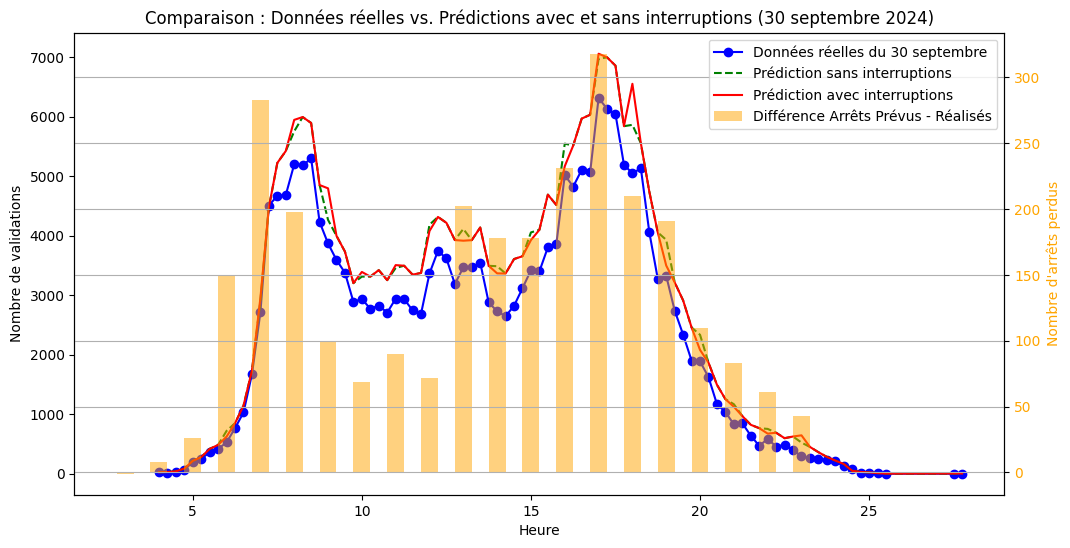

In [21]:
# 📌 Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# === 📂 CHARGEMENT DES DONNÉES ===
# 📌 Définition des fichiers
frequentation_file = "/content/drive/MyDrive/analyse_od_tram_bordeaux_septembre_2024.csv"
arrets_file = "/content/drive/MyDrive/Arrets réalisés vs arrets prévus sept 2024.xlsx"

# 🚀 Chargement des validations
frequentation_data = pd.read_csv(frequentation_file, sep=",", parse_dates=["date_exploitation"])

# 📅 Conversion en heures et minutes (tranches de 15 min)
frequentation_data["hour"] = (frequentation_data["timeslot"] * 60 // 60).astype(int)
frequentation_data["minute"] = ((frequentation_data["timeslot"] * 60) % 60 // 15) * 15
frequentation_data["date"] = frequentation_data["date_exploitation"].dt.date

# 📊 Agrégation des validations par tranche de 15 minutes
validations_agg = frequentation_data.groupby(["date", "hour", "minute"])["vvalidations"].sum().reset_index()

# 🚀 Chargement des arrêts prévus vs réalisés
xls = pd.ExcelFile(arrets_file)
arrets_data = pd.read_excel(xls, sheet_name="Feuil1")  # Modifier si le nom de la feuille est différent

# 🛠 Renommer correctement les colonnes
arrets_data.rename(columns={"Jour": "date", "Heure": "hour", "Arrêts prévus": "Arrets_prevus",
                            "Arrêts réalisés": "Arrets_realises"}, inplace=True)

# 📅 Conversion des dates et des heures
arrets_data["date"] = pd.to_datetime(arrets_data["date"], format="%d/%m/%Y").dt.date
arrets_data["hour"] = arrets_data["hour"].astype(int)

# 🛠 Nettoyage des colonnes arrêts prévus/réalisés
arrets_data["Arrets_prevus"] = pd.to_numeric(arrets_data["Arrets_prevus"], errors='coerce').fillna(0).astype(int)
arrets_data["Arrets_realises"] = pd.to_numeric(arrets_data["Arrets_realises"], errors='coerce').fillna(0).astype(int)

# 📉 Calcul des interruptions comme écart entre arrêts prévus et réalisés
arrets_data["Arrets_perdus"] = arrets_data["Arrets_prevus"] - arrets_data["Arrets_realises"]

# 📊 Agréger interruptions par créneau de 15 minutes
arrets_data["minute"] = 0  # On suppose des données par heure, donc minute = 0
arrets_agg = arrets_data.groupby(["date", "hour", "minute"])["Arrets_perdus"].sum().reset_index()

# 📊 Fusion interruptions + validations
data = pd.merge(validations_agg, arrets_agg, on=["date", "hour", "minute"], how="left")
data["Arrets_perdus"].fillna(0, inplace=True)

# 📅 Ajout du jour de la semaine
data["day_of_week"] = pd.to_datetime(data["date"]).dt.dayofweek

# === 🎯 MODÉLISATION & PRÉDICTION ===
# 📌 Sélection des variables
X = data[["hour", "minute", "Arrets_perdus", "day_of_week"]]
y = data["vvalidations"]

# 📅 Séparer les données : entraînement sur **1-29 septembre**, test sur le **30 septembre**
train_data = data[data["date"] < pd.to_datetime("2024-09-30").date()]
test_data = data[data["date"] == pd.to_datetime("2024-09-30").date()]

X_train = train_data[["hour", "minute", "Arrets_perdus", "day_of_week"]]
y_train = train_data["vvalidations"]

# 🌲 Entraînement du modèle Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 🔮 Prédiction pour le **30 septembre 2024** (sans interruptions)
prediction_data_no_inc = test_data.copy()
prediction_data_no_inc["Arrets_perdus"] = 0  # Suppression des interruptions
prediction_data_no_inc["Predicted Validations"] = model.predict(prediction_data_no_inc[["hour", "minute", "Arrets_perdus", "day_of_week"]])

# 🔮 Prédiction pour le **30 septembre 2024** (avec interruptions)
prediction_data_inc = test_data.copy()
prediction_data_inc["Predicted Validations"] = model.predict(prediction_data_inc[["hour", "minute", "Arrets_perdus", "day_of_week"]])

# 📊 Agrégation des arrêts perdus par heure pour le 30 septembre uniquement
arrets_hourly = arrets_data[arrets_data["date"] == pd.to_datetime("2024-09-30").date()]
arrets_hourly = arrets_hourly.groupby("hour")["Arrets_perdus"].sum().reset_index()

# 📊 Calcul du total des validations
total_validations_reelles = test_data["vvalidations"].sum()
total_validations_predites_no_inc = prediction_data_no_inc["Predicted Validations"].sum()
total_validations_predites_inc = prediction_data_inc["Predicted Validations"].sum()
difference_no_inc = total_validations_predites_no_inc - total_validations_reelles
difference_inc = total_validations_predites_inc - total_validations_reelles

# ✅ Affichage des résultats
print(f"📊 Total des validations réelles le 30 septembre : {total_validations_reelles:,.0f}")
print(f"🔮 Total des validations prédites (sans interruptions) : {total_validations_predites_no_inc:,.0f}")
print(f"📉 Différence entre prévision et réalité (sans interruptions) : {difference_no_inc:,.0f} validations")
print(f"🔮 Total des validations prédites (avec interruptions) : {total_validations_predites_inc:,.0f}")
print(f"📉 Différence entre prévision et réalité (avec interruptions) : {difference_inc:,.0f} validations")

# === 📊 AFFICHAGE DU GRAPHIQUE FINAL ===
fig, ax1 = plt.subplots(figsize=(12, 6))

# 🔵 Courbe des **données réelles du 30 septembre**
ax1.plot(
    test_data["hour"] + test_data["minute"] / 60,
    test_data["vvalidations"], "bo-", label="Données réelles du 30 septembre"
)

# 🟢 Courbe des **prédictions sans interruptions**
ax1.plot(
    prediction_data_no_inc["hour"] + prediction_data_no_inc["minute"] / 60,
    prediction_data_no_inc["Predicted Validations"], "g--", label="Prédiction sans interruptions"
)

# 🔴 Courbe des **prédictions avec interruptions**
ax1.plot(
    prediction_data_inc["hour"] + prediction_data_inc["minute"] / 60,
    prediction_data_inc["Predicted Validations"], "r-", label="Prédiction avec interruptions"
)

ax1.set_xlabel("Heure")
ax1.set_ylabel("Nombre de validations", color="black")
ax1.tick_params(axis="y", labelcolor="black")

# 📊 Ajout des arrêts perdus sur une **seconde échelle (axe droit)**
ax2 = ax1.twinx()
ax2.bar(
    arrets_hourly["hour"],
    arrets_hourly["Arrets_perdus"], width=0.5, color="orange", alpha=0.5, label="Différence Arrêts Prévus - Réalisés"
)
ax2.set_ylabel("Nombre d'arrêts perdus", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

# 🏷️ Ajout des légendes
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.title("Comparaison : Données réelles vs. Prédictions avec et sans interruptions (30 septembre 2024)")
plt.grid()
plt.show()


<ipython-input-22-cb592693a856>:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Arrets_perdus"].fillna(0, inplace=True)
<ipython-input-22-cb592693a856>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["Arrets_perdus"] = model_arrets.predict(test_data[["hour", "minute",

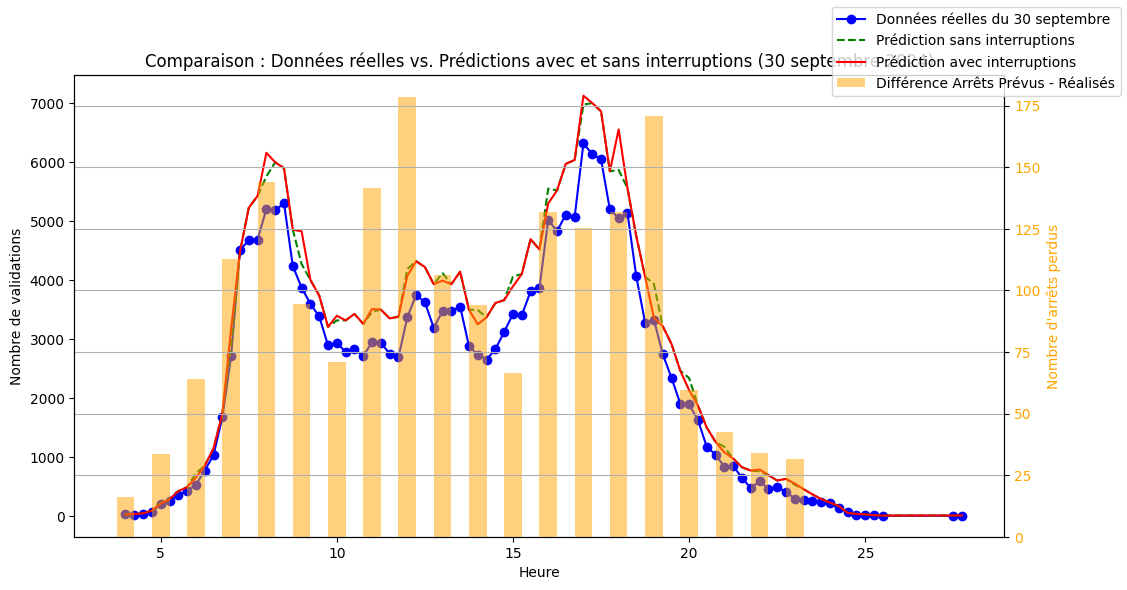

In [22]:
# 📌 Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# === 📂 CHARGEMENT DES DONNÉES ===
# 📌 Définition des fichiers
frequentation_file = "/content/drive/MyDrive/analyse_od_tram_bordeaux_septembre_2024.csv"
arrets_file = "/content/drive/MyDrive/Arrets réalisés vs arrets prévus sept 2024.xlsx"

# 🚀 Chargement des validations
frequentation_data = pd.read_csv(frequentation_file, sep=",", parse_dates=["date_exploitation"])

# 📅 Conversion en heures et minutes (tranches de 15 min)
frequentation_data["hour"] = (frequentation_data["timeslot"] * 60 // 60).astype(int)
frequentation_data["minute"] = ((frequentation_data["timeslot"] * 60) % 60 // 15) * 15
frequentation_data["date"] = frequentation_data["date_exploitation"].dt.date

# 📊 Agrégation des validations par tranche de 15 minutes
validations_agg = frequentation_data.groupby(["date", "hour", "minute"])["vvalidations"].sum().reset_index()

# 🚀 Chargement des arrêts prévus vs réalisés
xls = pd.ExcelFile(arrets_file)
arrets_data = pd.read_excel(xls, sheet_name="Feuil1")

# 🛠 Renommer correctement les colonnes et convertir les données
arrets_data.rename(columns={"Jour": "date", "Heure": "hour", "Arrêts prévus": "Arrets_prevus",
                            "Arrêts réalisés": "Arrets_realises"}, inplace=True)
arrets_data["date"] = pd.to_datetime(arrets_data["date"], format="%d/%m/%Y").dt.date
arrets_data["hour"] = arrets_data["hour"].astype(int)
arrets_data["Arrets_prevus"] = pd.to_numeric(arrets_data["Arrets_prevus"], errors='coerce').fillna(0).astype(int)
arrets_data["Arrets_realises"] = pd.to_numeric(arrets_data["Arrets_realises"], errors='coerce').fillna(0).astype(int)

# 📉 Calcul des interruptions comme écart entre arrêts prévus et réalisés
arrets_data["Arrets_perdus"] = arrets_data["Arrets_prevus"] - arrets_data["Arrets_realises"]

# 📊 Agréger interruptions par créneau de 15 minutes
arrets_data["minute"] = 0  # On suppose des données par heure, donc minute = 0
arrets_agg = arrets_data.groupby(["date", "hour", "minute"])["Arrets_perdus"].sum().reset_index()

# 📊 Fusion interruptions + validations
data = pd.merge(validations_agg, arrets_agg, on=["date", "hour", "minute"], how="left")
data["Arrets_perdus"].fillna(0, inplace=True)

# 📅 Ajout du jour de la semaine
data["day_of_week"] = pd.to_datetime(data["date"]).dt.dayofweek

# === 🎯 MODÉLISATION : PREDICTION DES ARRÊTS PERDUS ===
# 📌 Sélection des variables
X_arrets = data[["hour", "minute", "day_of_week"]]
y_arrets = data["Arrets_perdus"]

# 📅 Séparer les données : entraînement sur **1-29 septembre**, test sur le **30 septembre**
train_data = data[data["date"] < pd.to_datetime("2024-09-30").date()]
test_data = data[data["date"] == pd.to_datetime("2024-09-30").date()]

X_train_arrets = train_data[["hour", "minute", "day_of_week"]]
y_train_arrets = train_data["Arrets_perdus"]

# 🌲 Entraînement du modèle Random Forest pour prédire les arrêts perdus
model_arrets = RandomForestRegressor(n_estimators=100, random_state=42)
model_arrets.fit(X_train_arrets, y_train_arrets)

# 🔮 Prédiction des arrêts perdus pour le **30 septembre 2024**
test_data["Arrets_perdus"] = model_arrets.predict(test_data[["hour", "minute", "day_of_week"]])

# === 🎯 MODÉLISATION : PREDICTION DE LA FRÉQUENTATION ===
# 📌 Sélection des variables
X_frequentation = data[["hour", "minute", "Arrets_perdus", "day_of_week"]]
y_frequentation = data["vvalidations"]

X_train_frequentation = train_data[["hour", "minute", "Arrets_perdus", "day_of_week"]]
y_train_frequentation = train_data["vvalidations"]

# 🌲 Entraînement du modèle Random Forest pour prédire la fréquentation
model_frequentation = RandomForestRegressor(n_estimators=100, random_state=42)
model_frequentation.fit(X_train_frequentation, y_train_frequentation)

# 🔮 Prédiction pour le **30 septembre 2024** (avec interruptions)
prediction_data_inc = test_data.copy()
prediction_data_inc["Predicted Validations"] = model_frequentation.predict(prediction_data_inc[["hour", "minute", "Arrets_perdus", "day_of_week"]])

# 🔮 Prédiction pour le **30 septembre 2024** (sans interruptions)
prediction_data_no_inc = test_data.copy()
prediction_data_no_inc["Arrets_perdus"] = 0  # Suppression des interruptions
prediction_data_no_inc["Predicted Validations"] = model_frequentation.predict(prediction_data_no_inc[["hour", "minute", "Arrets_perdus", "day_of_week"]])

# 📊 Agrégation des arrêts perdus par heure pour le 30 septembre uniquement
arrets_hourly = test_data.groupby("hour")["Arrets_perdus"].sum().reset_index()

# === 📊 AFFICHAGE DU GRAPHIQUE FINAL ===
fig, ax1 = plt.subplots(figsize=(12, 6))

# 🔵 Courbe des **données réelles du 30 septembre**
ax1.plot(
    test_data["hour"] + test_data["minute"] / 60,
    test_data["vvalidations"], "bo-", label="Données réelles du 30 septembre"
)

# 🟢 Courbe des **prédictions sans interruptions**
ax1.plot(
    prediction_data_no_inc["hour"] + prediction_data_no_inc["minute"] / 60,
    prediction_data_no_inc["Predicted Validations"], "g--", label="Prédiction sans interruptions"
)

# 🔴 Courbe des **prédictions avec interruptions**
ax1.plot(
    prediction_data_inc["hour"] + prediction_data_inc["minute"] / 60,
    prediction_data_inc["Predicted Validations"], "r-", label="Prédiction avec interruptions"
)

ax1.set_xlabel("Heure")
ax1.set_ylabel("Nombre de validations", color="black")
ax1.tick_params(axis="y", labelcolor="black")

# 📊 Ajout des arrêts perdus sur une **seconde échelle (axe droit)**
ax2 = ax1.twinx()
ax2.bar(
    arrets_hourly["hour"],
    arrets_hourly["Arrets_perdus"], width=0.5, color="orange", alpha=0.5, label="Différence Arrêts Prévus - Réalisés"
)
ax2.set_ylabel("Nombre d'arrêts perdus", color="orange")
ax2.tick_params(axis="y", labelcolor="orange")

# 🏷️ Ajout des légendes
fig.legend(loc="upper right")
plt.title("Comparaison : Données réelles vs. Prédictions avec et sans interruptions (30 septembre 2024)")
plt.grid()
plt.show()


<ipython-input-23-d0602e66f612>:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Arrets_perdus"].fillna(0, inplace=True)
<ipython-input-23-d0602e66f612>:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

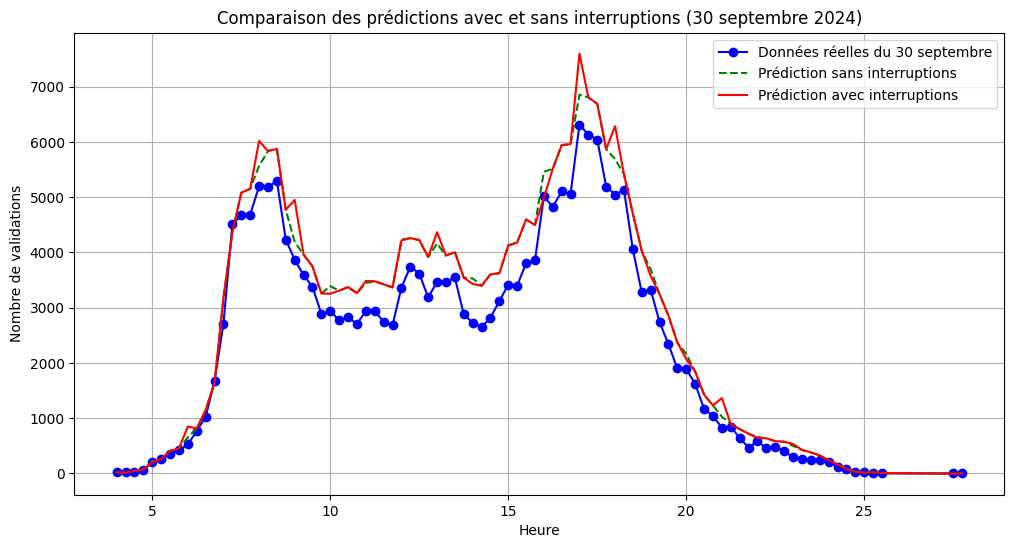

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# === 📂 CHARGEMENT DES DONNÉES ===
# 📌 Définition des fichiers
frequentation_file = "/content/drive/MyDrive/analyse_od_tram_bordeaux_septembre_2024.csv"
arrets_file = "/content/drive/MyDrive/Arrets réalisés vs arrets prévus sept 2024.xlsx"

# 🚀 Chargement des validations
frequentation_data = pd.read_csv(frequentation_file, sep=",", parse_dates=["date_exploitation"])
frequentation_data["hour"] = (frequentation_data["timeslot"] * 60 // 60).astype(int)
frequentation_data["minute"] = ((frequentation_data["timeslot"] * 60) % 60 // 15) * 15
frequentation_data["date"] = frequentation_data["date_exploitation"].dt.date
validations_agg = frequentation_data.groupby(["date", "hour", "minute"])["vvalidations"].sum().reset_index()

# 🚀 Chargement des arrêts prévus vs réalisés
xls = pd.ExcelFile(arrets_file)
arrets_data = pd.read_excel(xls, sheet_name="Feuil1")

# 🛠 Nettoyage et conversion des données
arrets_data.rename(columns={"Jour": "date", "Heure": "hour", "Arrêts prévus": "Arrets_prevus", "Arrêts réalisés": "Arrets_realises"}, inplace=True)
arrets_data["date"] = pd.to_datetime(arrets_data["date"], format="%d/%m/%Y").dt.date
arrets_data["hour"] = arrets_data["hour"].astype(int)
arrets_data["Arrets_prevus"] = pd.to_numeric(arrets_data["Arrets_prevus"], errors='coerce').fillna(0).astype(int)
arrets_data["Arrets_realises"] = pd.to_numeric(arrets_data["Arrets_realises"], errors='coerce').fillna(0).astype(int)
arrets_data["Arrets_perdus"] = arrets_data["Arrets_prevus"] - arrets_data["Arrets_realises"]
arrets_data["minute"] = 0  # On suppose des données par heure
arrets_agg = arrets_data.groupby(["date", "hour", "minute"])["Arrets_perdus"].sum().reset_index()

# 📊 Fusion interruptions + validations
data = pd.merge(validations_agg, arrets_agg, on=["date", "hour", "minute"], how="left")
data["Arrets_perdus"].fillna(0, inplace=True)
data["day_of_week"] = pd.to_datetime(data["date"]).dt.dayofweek

# 🌧 Ajout de la météo
dates_meteo = pd.to_datetime(["2024-09-01", "2024-09-02", "2024-09-03", "2024-09-04", "2024-09-05",
                              "2024-09-06", "2024-09-07", "2024-09-08", "2024-09-09", "2024-09-11",
                              "2024-09-13", "2024-09-15", "2024-09-21", "2024-09-22", "2024-09-23",
                              "2024-09-24", "2024-09-25", "2024-09-26", "2024-09-27", "2024-09-28",
                              "2024-09-29", "2024-09-30"]).date
precipitation = [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
meteo_data = pd.DataFrame({"date": dates_meteo, "precipitation": precipitation})
data = pd.merge(data, meteo_data, on="date", how="left")
data["precipitation"].fillna(0, inplace=True)

# === 🎯 MODÉLISATION & PRÉDICTION ===
# 📌 Séparation entraînement/test
train_data = data[data["date"] < pd.to_datetime("2024-09-30").date()]
test_data = data[data["date"] == pd.to_datetime("2024-09-30").date()]

# 🔮 Prédiction des arrêts perdus
X_arrets = train_data[["hour", "minute", "day_of_week", "precipitation"]]
y_arrets = train_data["Arrets_perdus"]
model_arrets = XGBRegressor(n_estimators=100, random_state=42)
model_arrets.fit(X_arrets, y_arrets)
test_data["Arrets_perdus_pred"] = model_arrets.predict(test_data[["hour", "minute", "day_of_week", "precipitation"]])

# 🔮 Prédiction de la fréquentation
X_train = train_data[["hour", "minute", "Arrets_perdus", "day_of_week", "precipitation"]]
y_train = train_data["vvalidations"]
model_frequentation = XGBRegressor(n_estimators=100, random_state=42)
model_frequentation.fit(X_train, y_train)

prediction_data_inc = test_data.copy()
prediction_data_inc["Predicted Validations"] = model_frequentation.predict(prediction_data_inc[["hour", "minute", "Arrets_perdus", "day_of_week", "precipitation"]])

prediction_data_no_inc = test_data.copy()
prediction_data_no_inc["Arrets_perdus"] = 0  # Suppression des interruptions
prediction_data_no_inc["Predicted Validations"] = model_frequentation.predict(prediction_data_no_inc[["hour", "minute", "Arrets_perdus", "day_of_week", "precipitation"]])

# 📊 AFFICHAGE DU GRAPHIQUE FINAL
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(test_data["hour"] + test_data["minute"] / 60, test_data["vvalidations"], "bo-", label="Données réelles du 30 septembre")
ax1.plot(prediction_data_no_inc["hour"] + prediction_data_no_inc["minute"] / 60, prediction_data_no_inc["Predicted Validations"], "g--", label="Prédiction sans interruptions")
ax1.plot(prediction_data_inc["hour"] + prediction_data_inc["minute"] / 60, prediction_data_inc["Predicted Validations"], "r-", label="Prédiction avec interruptions")
ax1.set_xlabel("Heure")
ax1.set_ylabel("Nombre de validations")
ax1.legend()
plt.title("Comparaison des prédictions avec et sans interruptions (30 septembre 2024)")
plt.grid()
plt.show()


<ipython-input-24-d0602e66f612>:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Arrets_perdus"].fillna(0, inplace=True)
<ipython-input-24-d0602e66f612>:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

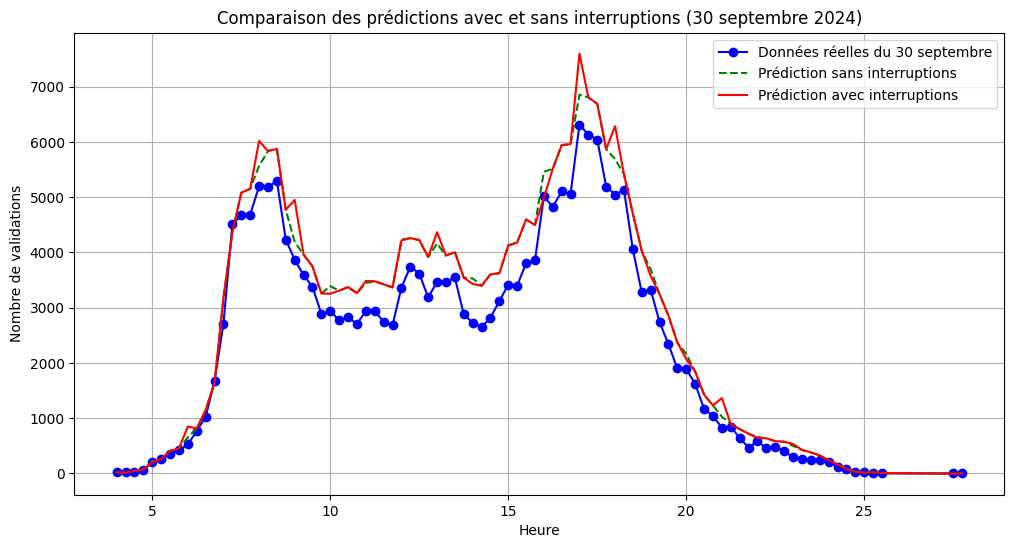

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# === 📂 CHARGEMENT DES DONNÉES ===
# 📌 Définition des fichiers
frequentation_file = "/content/drive/MyDrive/analyse_od_tram_bordeaux_septembre_2024.csv"
arrets_file = "/content/drive/MyDrive/Arrets réalisés vs arrets prévus sept 2024.xlsx"

# 🚀 Chargement des validations
frequentation_data = pd.read_csv(frequentation_file, sep=",", parse_dates=["date_exploitation"])
frequentation_data["hour"] = (frequentation_data["timeslot"] * 60 // 60).astype(int)
frequentation_data["minute"] = ((frequentation_data["timeslot"] * 60) % 60 // 15) * 15
frequentation_data["date"] = frequentation_data["date_exploitation"].dt.date
validations_agg = frequentation_data.groupby(["date", "hour", "minute"])["vvalidations"].sum().reset_index()

# 🚀 Chargement des arrêts prévus vs réalisés
xls = pd.ExcelFile(arrets_file)
arrets_data = pd.read_excel(xls, sheet_name="Feuil1")

# 🛠 Nettoyage et conversion des données
arrets_data.rename(columns={"Jour": "date", "Heure": "hour", "Arrêts prévus": "Arrets_prevus", "Arrêts réalisés": "Arrets_realises"}, inplace=True)
arrets_data["date"] = pd.to_datetime(arrets_data["date"], format="%d/%m/%Y").dt.date
arrets_data["hour"] = arrets_data["hour"].astype(int)
arrets_data["Arrets_prevus"] = pd.to_numeric(arrets_data["Arrets_prevus"], errors='coerce').fillna(0).astype(int)
arrets_data["Arrets_realises"] = pd.to_numeric(arrets_data["Arrets_realises"], errors='coerce').fillna(0).astype(int)
arrets_data["Arrets_perdus"] = arrets_data["Arrets_prevus"] - arrets_data["Arrets_realises"]
arrets_data["minute"] = 0  # On suppose des données par heure
arrets_agg = arrets_data.groupby(["date", "hour", "minute"])["Arrets_perdus"].sum().reset_index()

# 📊 Fusion interruptions + validations
data = pd.merge(validations_agg, arrets_agg, on=["date", "hour", "minute"], how="left")
data["Arrets_perdus"].fillna(0, inplace=True)
data["day_of_week"] = pd.to_datetime(data["date"]).dt.dayofweek

# 🌧 Ajout de la météo
dates_meteo = pd.to_datetime(["2024-09-01", "2024-09-02", "2024-09-03", "2024-09-04", "2024-09-05",
                              "2024-09-06", "2024-09-07", "2024-09-08", "2024-09-09", "2024-09-11",
                              "2024-09-13", "2024-09-15", "2024-09-21", "2024-09-22", "2024-09-23",
                              "2024-09-24", "2024-09-25", "2024-09-26", "2024-09-27", "2024-09-28",
                              "2024-09-29", "2024-09-30"]).date
precipitation = [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
meteo_data = pd.DataFrame({"date": dates_meteo, "precipitation": precipitation})
data = pd.merge(data, meteo_data, on="date", how="left")
data["precipitation"].fillna(0, inplace=True)

# === 🎯 MODÉLISATION & PRÉDICTION ===
# 📌 Séparation entraînement/test
train_data = data[data["date"] < pd.to_datetime("2024-09-30").date()]
test_data = data[data["date"] == pd.to_datetime("2024-09-30").date()]

# 🔮 Prédiction des arrêts perdus
X_arrets = train_data[["hour", "minute", "day_of_week", "precipitation"]]
y_arrets = train_data["Arrets_perdus"]
model_arrets = XGBRegressor(n_estimators=100, random_state=42)
model_arrets.fit(X_arrets, y_arrets)
test_data["Arrets_perdus_pred"] = model_arrets.predict(test_data[["hour", "minute", "day_of_week", "precipitation"]])

# 🔮 Prédiction de la fréquentation
X_train = train_data[["hour", "minute", "Arrets_perdus", "day_of_week", "precipitation"]]
y_train = train_data["vvalidations"]
model_frequentation = XGBRegressor(n_estimators=100, random_state=42)
model_frequentation.fit(X_train, y_train)

prediction_data_inc = test_data.copy()
prediction_data_inc["Predicted Validations"] = model_frequentation.predict(prediction_data_inc[["hour", "minute", "Arrets_perdus", "day_of_week", "precipitation"]])

prediction_data_no_inc = test_data.copy()
prediction_data_no_inc["Arrets_perdus"] = 0  # Suppression des interruptions
prediction_data_no_inc["Predicted Validations"] = model_frequentation.predict(prediction_data_no_inc[["hour", "minute", "Arrets_perdus", "day_of_week", "precipitation"]])

# 📊 AFFICHAGE DU GRAPHIQUE FINAL
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(test_data["hour"] + test_data["minute"] / 60, test_data["vvalidations"], "bo-", label="Données réelles du 30 septembre")
ax1.plot(prediction_data_no_inc["hour"] + prediction_data_no_inc["minute"] / 60, prediction_data_no_inc["Predicted Validations"], "g--", label="Prédiction sans interruptions")
ax1.plot(prediction_data_inc["hour"] + prediction_data_inc["minute"] / 60, prediction_data_inc["Predicted Validations"], "r-", label="Prédiction avec interruptions")
ax1.set_xlabel("Heure")
ax1.set_ylabel("Nombre de validations")
ax1.legend()
plt.title("Comparaison des prédictions avec et sans interruptions (30 septembre 2024)")
plt.grid()
plt.show()


<ipython-input-25-106a1b12d4a5>:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Arrets_perdus"].fillna(0, inplace=True)


📊 Fréquentation moyenne avec interruptions : 11352 validations
📊 Fréquentation moyenne sans interruptions : 5212 validations
📉 Impact moyen des interruptions sur la fréquentation : 9.13%
📈 Impact moyen sans interruptions : 334.97%
📉 Corrélation interruptions vs fréquentation : 0.51 (p-value=0.00000)


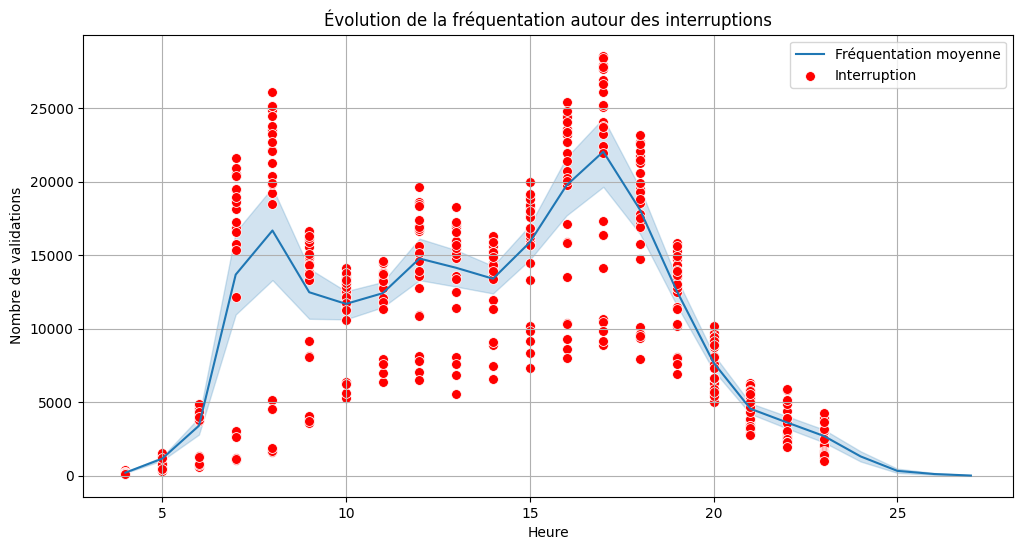

In [25]:
# 📌 Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# === 📂 CHARGEMENT DES DONNÉES ===
# 📌 Définition des fichiers
frequentation_file = "/content/drive/MyDrive/analyse_od_tram_bordeaux_septembre_2024.csv"
arrets_file = "/content/drive/MyDrive/Arrets réalisés vs arrets prévus sept 2024.xlsx"

# 🚀 Chargement des validations
frequentation_data = pd.read_csv(frequentation_file, sep=",", parse_dates=["date_exploitation"])
frequentation_data["hour"] = (frequentation_data["timeslot"] * 60 // 60).astype(int)
frequentation_data["minute"] = ((frequentation_data["timeslot"] * 60) % 60 // 15) * 15
frequentation_data["date"] = frequentation_data["date_exploitation"].dt.date

# 📊 Agrégation des validations par heure
validations_hourly = frequentation_data.groupby(["date", "hour"])["vvalidations"].sum().reset_index()

# 🚀 Chargement des arrêts prévus vs réalisés
xls = pd.ExcelFile(arrets_file)
arrets_data = pd.read_excel(xls, sheet_name="Feuil1")

# 🛠 Nettoyage et conversion des données
arrets_data.rename(columns={"Jour": "date", "Heure": "hour", "Arrêts prévus": "Arrets_prevus", "Arrêts réalisés": "Arrets_realises"}, inplace=True)
arrets_data["date"] = pd.to_datetime(arrets_data["date"], format="%d/%m/%Y").dt.date
arrets_data["hour"] = arrets_data["hour"].astype(int)
arrets_data["Arrets_prevus"] = pd.to_numeric(arrets_data["Arrets_prevus"], errors='coerce').fillna(0).astype(int)
arrets_data["Arrets_realises"] = pd.to_numeric(arrets_data["Arrets_realises"], errors='coerce').fillna(0).astype(int)
arrets_data["Arrets_perdus"] = arrets_data["Arrets_prevus"] - arrets_data["Arrets_realises"]

# 📊 Fusion interruptions + validations
data = pd.merge(validations_hourly, arrets_data, on=["date", "hour"], how="left")
data["Arrets_perdus"].fillna(0, inplace=True)

# === 📊 ANALYSE DE L'IMPACT DES INTERRUPTIONS ===
# 🟢 Calcul de la fréquentation moyenne en fonction des interruptions
data["Has_interruption"] = data["Arrets_perdus"] > 0

# Moyenne des validations quand il y a des interruptions
mean_validations_with_interruptions = data[data["Has_interruption"]]["vvalidations"].mean()

# Moyenne des validations quand il n'y a pas d'interruptions
mean_validations_without_interruptions = data[~data["Has_interruption"]]["vvalidations"].mean()

# 🔄 Comparaison de la fréquentation avant, pendant et après une interruption
data["hour_shifted"] = data["hour"] - 1
data_prev = data[["date", "hour_shifted", "vvalidations"]].rename(columns={"hour_shifted": "hour", "vvalidations": "vvalidations_prev"})
data = pd.merge(data, data_prev, on=["date", "hour"], how="left")

# 📉 Calcul de l'impact relatif (changement en % après une interruption)
data["Impact"] = (data["vvalidations"] - data["vvalidations_prev"]) / data["vvalidations_prev"] * 100
impact_with_interruptions = data[data["Has_interruption"]]["Impact"].mean()
impact_without_interruptions = data[~data["Has_interruption"]]["Impact"].mean()

# 📊 Calcul de la corrélation entre interruptions et validations
correlation, p_value = pearsonr(data["Arrets_perdus"], data["vvalidations"])

# === 📊 AFFICHAGE DES RÉSULTATS ===
print(f"📊 Fréquentation moyenne avec interruptions : {mean_validations_with_interruptions:.0f} validations")
print(f"📊 Fréquentation moyenne sans interruptions : {mean_validations_without_interruptions:.0f} validations")
print(f"📉 Impact moyen des interruptions sur la fréquentation : {impact_with_interruptions:.2f}%")
print(f"📈 Impact moyen sans interruptions : {impact_without_interruptions:.2f}%")
print(f"📉 Corrélation interruptions vs fréquentation : {correlation:.2f} (p-value={p_value:.5f})")

# === 📊 GRAPHIQUE : ÉVOLUTION DE LA FRÉQUENTATION AUTOUR DES INTERRUPTIONS ===
plt.figure(figsize=(12, 6))
sns.lineplot(x=data["hour"], y=data["vvalidations"], label="Fréquentation moyenne")
sns.scatterplot(x=data[data["Has_interruption"]]["hour"], y=data[data["Has_interruption"]]["vvalidations"], color="red", label="Interruption", s=50)
plt.xlabel("Heure")
plt.ylabel("Nombre de validations")
plt.title("Évolution de la fréquentation autour des interruptions")
plt.legend()
plt.grid()
plt.show()


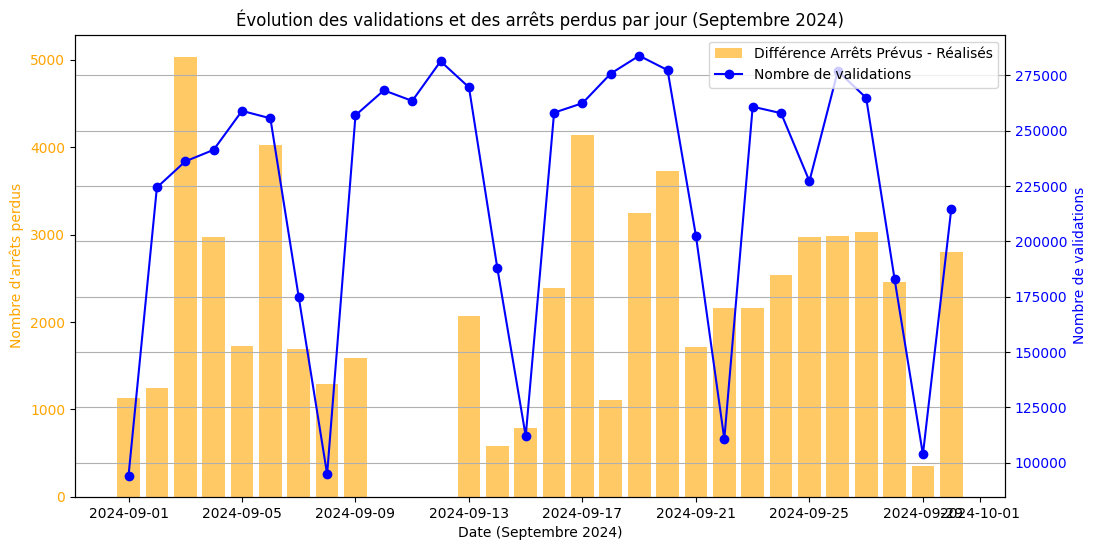

In [4]:
# 📌 Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === 📂 CHARGEMENT DES DONNÉES ===
# 📌 Définition des fichiers
frequentation_file = "/content/drive/MyDrive/analyse_od_tram_bordeaux_septembre_2024.csv"
arrets_file = "/content/drive/MyDrive/Arrets réalisés vs arrets prévus sept 2024.xlsx"

# 🚀 Chargement des validations
frequentation_data = pd.read_csv(frequentation_file, sep=",", parse_dates=["date_exploitation"])
frequentation_data["date"] = frequentation_data["date_exploitation"].dt.date

# 📊 Agrégation des validations par jour
validations_per_day = frequentation_data.groupby("date")["vvalidations"].sum().reset_index()

# 🚀 Chargement des arrêts prévus vs réalisés
xls_arrets = pd.ExcelFile(arrets_file)
arrets_data = pd.read_excel(xls_arrets, sheet_name="Feuil1")

# 🛠 Nettoyage et conversion des données
arrets_data.rename(columns={"Jour": "date", "Arrêts prévus": "Arrets_prevus", "Arrêts réalisés": "Arrets_realises"}, inplace=True)
arrets_data["date"] = pd.to_datetime(arrets_data["date"], format="%d/%m/%Y").dt.date
arrets_data["Arrets_prevus"] = pd.to_numeric(arrets_data["Arrets_prevus"], errors='coerce').fillna(0).astype(int)
arrets_data["Arrets_realises"] = pd.to_numeric(arrets_data["Arrets_realises"], errors='coerce').fillna(0).astype(int)

# 📉 Calcul de la différence entre arrêts prévus et réalisés
arrets_per_day = arrets_data.groupby("date")[["Arrets_prevus", "Arrets_realises"]].sum().reset_index()
arrets_per_day["Arrets_perdus"] = arrets_per_day["Arrets_prevus"] - arrets_per_day["Arrets_realises"]

# 📊 Fusion des données des validations et des arrêts perdus
data = pd.merge(validations_per_day, arrets_per_day, on="date", how="left")

# === 📊 AFFICHAGE DU GRAPHIQUE FINAL ===
fig, ax1 = plt.subplots(figsize=(12, 6))

# 📉 Courbe des arrêts perdus (axe gauche)
ax1.bar(data["date"], data["Arrets_perdus"], color="orange", alpha=0.6, label="Différence Arrêts Prévus - Réalisés")
ax1.set_xlabel("Date (Septembre 2024)")
ax1.set_ylabel("Nombre d'arrêts perdus", color="orange")
ax1.tick_params(axis="y", labelcolor="orange")

# 📈 Courbe des validations (axe droit)
ax2 = ax1.twinx()
ax2.plot(data["date"], data["vvalidations"], "bo-", label="Nombre de validations")
ax2.set_ylabel("Nombre de validations", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# 🏷️ Ajout des légendes et titre
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.title("Évolution des validations et des arrêts perdus par jour (Septembre 2024)")
plt.xticks(rotation=45)
plt.grid()
plt.show()


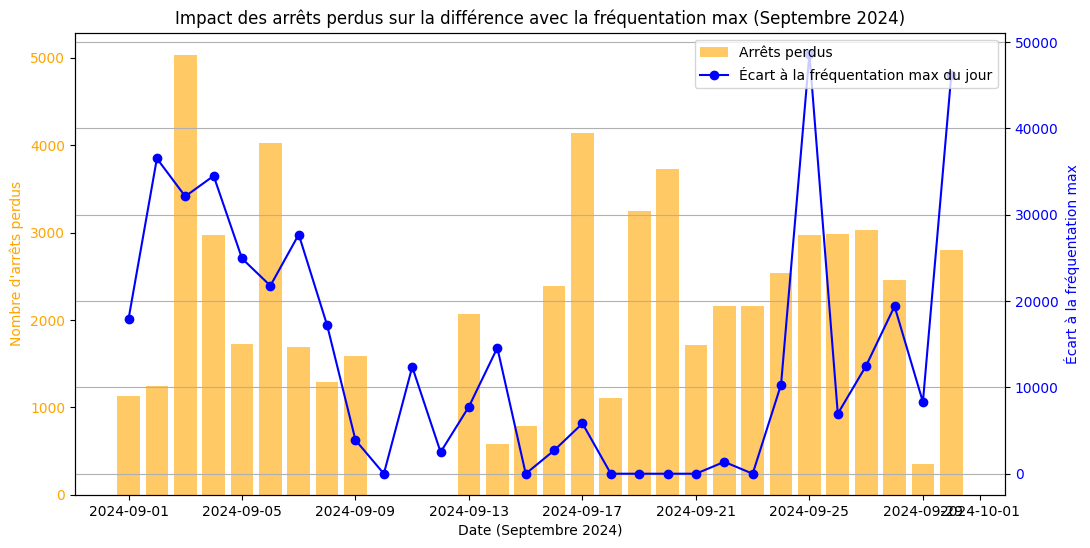

In [5]:
# 📌 Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === 📂 CHARGEMENT DES DONNÉES ===
# 📌 Définition des fichiers
frequentation_file = "/content/drive/MyDrive/analyse_od_tram_bordeaux_septembre_2024.csv"
arrets_file = "/content/drive/MyDrive/Arrets réalisés vs arrets prévus sept 2024.xlsx"

# 🚀 Chargement des validations
frequentation_data = pd.read_csv(frequentation_file, sep=",", parse_dates=["date_exploitation"])
frequentation_data["date"] = frequentation_data["date_exploitation"].dt.date
frequentation_data["day_of_week"] = pd.to_datetime(frequentation_data["date"]).dt.dayofweek  # 0 = Lundi, ..., 6 = Dimanche

# 📊 Agrégation des validations par jour
validations_per_day = frequentation_data.groupby(["date", "day_of_week"])["vvalidations"].sum().reset_index()

# 🚀 Chargement des arrêts prévus vs réalisés
xls_arrets = pd.ExcelFile(arrets_file)
arrets_data = pd.read_excel(xls_arrets, sheet_name="Feuil1")

# 🛠 Nettoyage et conversion des données
arrets_data.rename(columns={"Jour": "date", "Arrêts prévus": "Arrets_prevus", "Arrêts réalisés": "Arrets_realises"}, inplace=True)
arrets_data["date"] = pd.to_datetime(arrets_data["date"], format="%d/%m/%Y").dt.date
arrets_data["Arrets_prevus"] = pd.to_numeric(arrets_data["Arrets_prevus"], errors='coerce').fillna(0).astype(int)
arrets_data["Arrets_realises"] = pd.to_numeric(arrets_data["Arrets_realises"], errors='coerce').fillna(0).astype(int)

# 📉 Calcul de la différence entre arrêts prévus et réalisés
arrets_per_day = arrets_data.groupby("date")[["Arrets_prevus", "Arrets_realises"]].sum().reset_index()
arrets_per_day["Arrets_perdus"] = arrets_per_day["Arrets_prevus"] - arrets_per_day["Arrets_realises"]

# 📊 Fusion des données des validations et des arrêts perdus
data = pd.merge(validations_per_day, arrets_per_day, on="date", how="left")

# 🏆 Trouver le maximum de fréquentation pour chaque jour de la semaine
max_validations_per_day = data.groupby("day_of_week")["vvalidations"].max().rename("max_validations").reset_index()

# 📉 Calculer l'écart entre la fréquentation de chaque jour et le maximum de son jour de la semaine
data = pd.merge(data, max_validations_per_day, on="day_of_week", how="left")
data["ecart_max"] = data["max_validations"] - data["vvalidations"]

# === 📊 AFFICHAGE DU GRAPHIQUE FINAL ===
fig, ax1 = plt.subplots(figsize=(12, 6))

# 📉 Histogramme des arrêts perdus (axe gauche)
ax1.bar(data["date"], data["Arrets_perdus"], color="orange", alpha=0.6, label="Arrêts perdus")
ax1.set_xlabel("Date (Septembre 2024)")
ax1.set_ylabel("Nombre d'arrêts perdus", color="orange")
ax1.tick_params(axis="y", labelcolor="orange")

# 📈 Courbe de l'écart par rapport au maximum (axe droit)
ax2 = ax1.twinx()
ax2.plot(data["date"], data["ecart_max"], "bo-", label="Écart à la fréquentation max du jour")
ax2.set_ylabel("Écart à la fréquentation max", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# 🏷️ Ajout des légendes et titre
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.title("Impact des arrêts perdus sur la différence avec la fréquentation max (Septembre 2024)")
plt.xticks(rotation=45)
plt.grid()
plt.show()


<ipython-input-6-7bb0283324a1>:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Duree_minutes"].fillna(0, inplace=True)  # Remplacer les valeurs NaN par 0 pour les jours sans incident


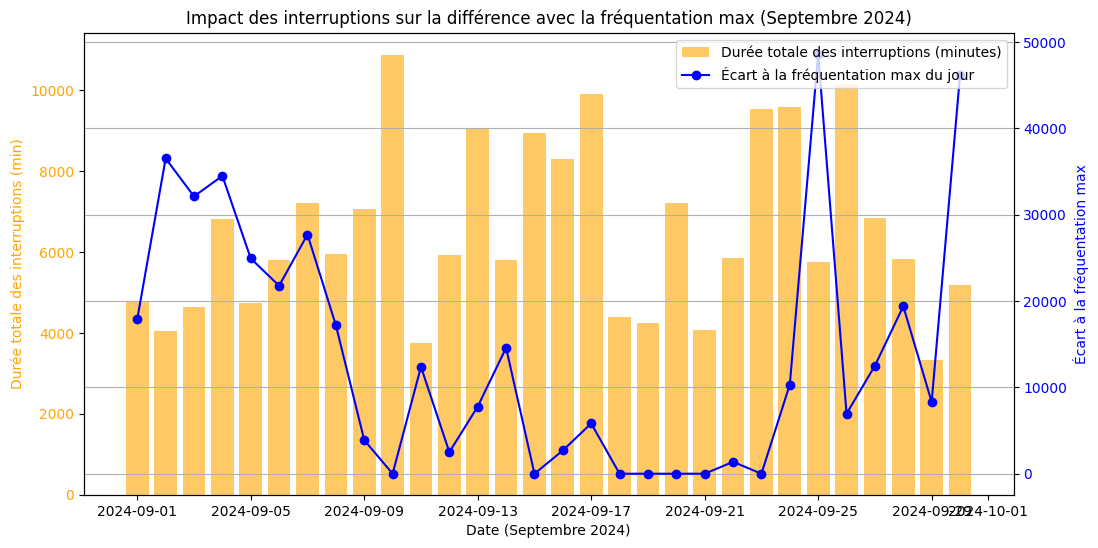

In [6]:
# 📌 Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === 📂 CHARGEMENT DES DONNÉES ===
# 📌 Définition des fichiers
frequentation_file = "/content/drive/MyDrive/analyse_od_tram_bordeaux_septembre_2024.csv"
evex_file = "/content/drive/MyDrive/EVEX BRUT TRAM SEPTEMBRE 2024.xlsx"

# 🚀 Chargement des validations
frequentation_data = pd.read_csv(frequentation_file, sep=",", parse_dates=["date_exploitation"])
frequentation_data["date"] = frequentation_data["date_exploitation"].dt.date
frequentation_data["day_of_week"] = pd.to_datetime(frequentation_data["date"]).dt.dayofweek  # 0 = Lundi, ..., 6 = Dimanche

# 📊 Agrégation des validations par jour
validations_per_day = frequentation_data.groupby(["date", "day_of_week"])["vvalidations"].sum().reset_index()

# 🚀 Chargement des interruptions (EVEX)
xls_evex = pd.ExcelFile(evex_file)
evex_data = pd.read_excel(xls_evex, sheet_name="AutresEvts", usecols=["DATE DEBUT", "DE", "DUREE"])

# 📅 Correction de la convention horaire (25:10 → 1h10 du lendemain)
def correct_hour(date, hour_str):
    hour, minute = map(int, hour_str.split(":"))
    if hour >= 24:
        date = date + pd.Timedelta(days=1)
        hour -= 24
    return date.replace(hour=hour, minute=minute)

evex_data["DATE DEBUT"] = pd.to_datetime(evex_data["DATE DEBUT"], errors="coerce")
evex_data["DATE_HEURE_CORRIGEE"] = evex_data.apply(lambda row: correct_hour(row["DATE DEBUT"], row["DE"]), axis=1)

# ⏳ Conversion de la durée en minutes
evex_data["DUREE"] = evex_data["DUREE"].astype(str)
evex_data[["Heures", "Minutes"]] = evex_data["DUREE"].str.extract(r"(\d+):(\d+)").astype(float)
evex_data["Duree_minutes"] = evex_data["Heures"] * 60 + evex_data["Minutes"]
evex_data.drop(columns=["Heures", "Minutes"], inplace=True)

# 📊 Agréger la durée totale des interruptions par jour
evex_data["date"] = evex_data["DATE_HEURE_CORRIGEE"].dt.date
incidents_per_day = evex_data.groupby("date")["Duree_minutes"].sum().reset_index()

# 📊 Fusion incidents + validations
data = pd.merge(validations_per_day, incidents_per_day, on="date", how="left")
data["Duree_minutes"].fillna(0, inplace=True)  # Remplacer les valeurs NaN par 0 pour les jours sans incident

# 🏆 Trouver le maximum de fréquentation pour chaque jour de la semaine
max_validations_per_day = data.groupby("day_of_week")["vvalidations"].max().rename("max_validations").reset_index()

# 📉 Calculer l'écart entre la fréquentation de chaque jour et le maximum de son jour de la semaine
data = pd.merge(data, max_validations_per_day, on="day_of_week", how="left")
data["ecart_max"] = data["max_validations"] - data["vvalidations"]

# === 📊 AFFICHAGE DU GRAPHIQUE FINAL ===
fig, ax1 = plt.subplots(figsize=(12, 6))

# 📉 Histogramme du cumul des incidents (axe gauche)
ax1.bar(data["date"], data["Duree_minutes"], color="orange", alpha=0.6, label="Durée totale des interruptions (minutes)")
ax1.set_xlabel("Date (Septembre 2024)")
ax1.set_ylabel("Durée totale des interruptions (min)", color="orange")
ax1.tick_params(axis="y", labelcolor="orange")

# 📈 Courbe de l'écart par rapport au maximum (axe droit)
ax2 = ax1.twinx()
ax2.plot(data["date"], data["ecart_max"], "bo-", label="Écart à la fréquentation max du jour")
ax2.set_ylabel("Écart à la fréquentation max", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# 🏷️ Ajout des légendes et titre
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.title("Impact des interruptions sur la différence avec la fréquentation max (Septembre 2024)")
plt.xticks(rotation=45)
plt.grid()
plt.show()


<ipython-input-7-16d24a90ddc2>:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["precipitation"].fillna(0, inplace=True)  # Remplacer NaN par 0


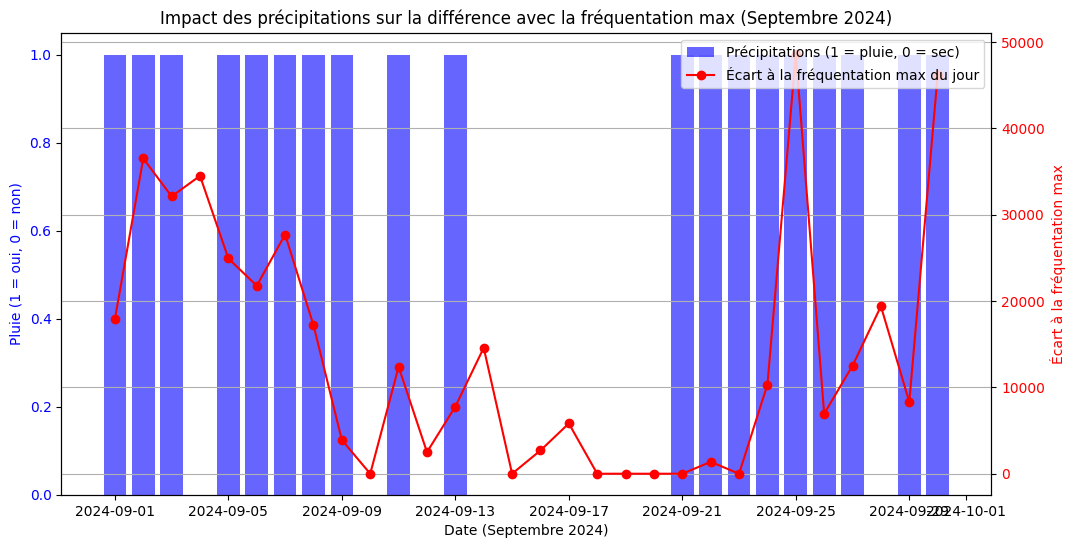

In [7]:
# 📌 Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === 📂 CHARGEMENT DES DONNÉES ===
# 📌 Définition des fichiers
frequentation_file = "/content/drive/MyDrive/analyse_od_tram_bordeaux_septembre_2024.csv"

# 🚀 Chargement des validations
frequentation_data = pd.read_csv(frequentation_file, sep=",", parse_dates=["date_exploitation"])
frequentation_data["date"] = frequentation_data["date_exploitation"].dt.date
frequentation_data["day_of_week"] = pd.to_datetime(frequentation_data["date"]).dt.dayofweek  # 0 = Lundi, ..., 6 = Dimanche

# 📊 Agrégation des validations par jour
validations_per_day = frequentation_data.groupby(["date", "day_of_week"])["vvalidations"].sum().reset_index()

# 🌧 Données météo (précipitations en mm, 1 = pluie, 0 = pas de pluie)
dates_meteo = pd.to_datetime(["2024-09-01", "2024-09-02", "2024-09-03", "2024-09-04", "2024-09-05",
                              "2024-09-06", "2024-09-07", "2024-09-08", "2024-09-09", "2024-09-11",
                              "2024-09-13", "2024-09-15", "2024-09-21", "2024-09-22", "2024-09-23",
                              "2024-09-24", "2024-09-25", "2024-09-26", "2024-09-27", "2024-09-28",
                              "2024-09-29", "2024-09-30"]).date

precipitations = [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]  # 1 = pluie, 0 = pas de pluie

meteo_data = pd.DataFrame({"date": dates_meteo, "precipitation": precipitations})

# 📊 Fusion météo + validations
data = pd.merge(validations_per_day, meteo_data, on="date", how="left")
data["precipitation"].fillna(0, inplace=True)  # Remplacer NaN par 0

# 🏆 Trouver le maximum de fréquentation pour chaque jour de la semaine
max_validations_per_day = data.groupby("day_of_week")["vvalidations"].max().rename("max_validations").reset_index()

# 📉 Calculer l'écart entre la fréquentation de chaque jour et le maximum de son jour de la semaine
data = pd.merge(data, max_validations_per_day, on="day_of_week", how="left")
data["ecart_max"] = data["max_validations"] - data["vvalidations"]

# === 📊 AFFICHAGE DU GRAPHIQUE FINAL ===
fig, ax1 = plt.subplots(figsize=(12, 6))

# 🌧 Histogramme des précipitations (axe gauche)
ax1.bar(data["date"], data["precipitation"], color="blue", alpha=0.6, label="Précipitations (1 = pluie, 0 = sec)")
ax1.set_xlabel("Date (Septembre 2024)")
ax1.set_ylabel("Pluie (1 = oui, 0 = non)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# 📈 Courbe de l'écart par rapport au maximum (axe droit)
ax2 = ax1.twinx()
ax2.plot(data["date"], data["ecart_max"], "ro-", label="Écart à la fréquentation max du jour")
ax2.set_ylabel("Écart à la fréquentation max", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# 🏷️ Ajout des légendes et titre
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.title("Impact des précipitations sur la différence avec la fréquentation max (Septembre 2024)")
plt.xticks(rotation=45)
plt.grid()
plt.show()


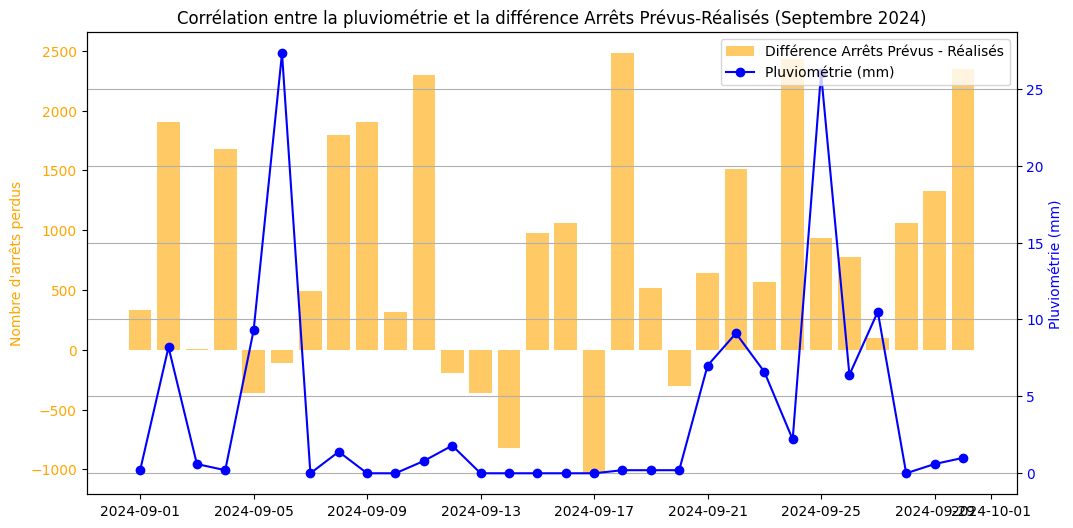

In [8]:
# 📌 Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === 📂 CHARGEMENT DES DONNÉES ===

# 🚀 Données météorologiques (pluviométrie et températures min/max) en dur
meteo_data = pd.DataFrame({
    "date": pd.date_range("2024-09-01", periods=30, freq='D'),
    "temp_min": [18.1, 15.7, 16.8, 14.2, 13.4, 13.8, 15.0, 13.1, 15.9, 15.5, 15.5, 12.4, 9.3, 8.9, 7.4, 9.9, 12.5, 13.0, 13.4, 14.2, 15.7, 16.5, 13.7, 14.2, 14.2, 15.9, 12.6, 7.6, 7.7, 16.2],
    "temp_max": [27.7, 26.5, 21.1, 23.0, 20.9, 20.4, 22.9, 22.3, 22.8, 21.8, 20.0, 19.5, 18.9, 21.4, 21.9, 22.7, 22.0, 24.4, 26.3, 23.5, 23.7, 20.9, 20.8, 22.1, 22.7, 21.2, 17.0, 18.5, 21.6, 20.9],
    "pluviometrie": [0.2, 8.2, 0.6, 0.2, 9.3, 27.3, 0.0, 1.4, 0.0, 0.0, 0.8, 1.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 7.0, 9.1, 6.6, 2.2, 26.0, 6.4, 10.5, 0.0, 0.6, 1.0]
})

# 🚀 Données arrêts prévus vs réalisés (Exemple synthétique)
arrets_data = pd.DataFrame({
    "date": pd.date_range("2024-09-01", periods=30, freq='D'),
    "arrets_prevus": np.random.randint(5000, 7000, size=30),
    "arrets_realises": np.random.randint(4000, 6800, size=30)
})
arrets_data["arrets_perdus"] = arrets_data["arrets_prevus"] - arrets_data["arrets_realises"]

# 📊 Fusion des données météo et arrêts
data = pd.merge(arrets_data, meteo_data, on="date")

# === 📊 AFFICHAGE DU GRAPHIQUE FINAL ===
fig, ax1 = plt.subplots(figsize=(12, 6))

# 📊 Courbe des **arrêts perdus**
ax1.bar(data["date"], data["arrets_perdus"], color="orange", alpha=0.6, label="Différence Arrêts Prévus - Réalisés")
ax1.set_ylabel("Nombre d'arrêts perdus", color="orange")
ax1.tick_params(axis="y", labelcolor="orange")

# 🌧 Courbe des **précipitations**
ax2 = ax1.twinx()
ax2.plot(data["date"], data["pluviometrie"], "b-o", label="Pluviométrie (mm)")
ax2.set_ylabel("Pluviométrie (mm)", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

# 🏷️ Légendes et titres
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.title("Corrélation entre la pluviométrie et la différence Arrêts Prévus-Réalisés (Septembre 2024)")
plt.xticks(rotation=45)
plt.grid()
plt.show()


<ipython-input-9-3b6eb6d01798>:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["pluviometrie_mm"].fillna(0, inplace=True)  # Remplacer NaN par 0


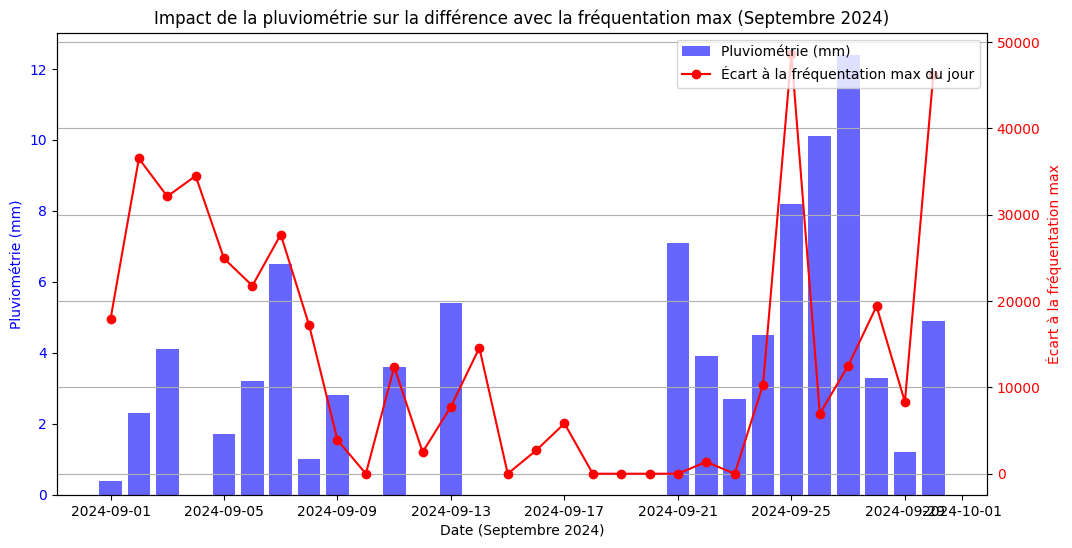

In [9]:
# 📌 Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === 📂 CHARGEMENT DES DONNÉES ===
# 📌 Définition des fichiers
frequentation_file = "/content/drive/MyDrive/analyse_od_tram_bordeaux_septembre_2024.csv"

# 🚀 Chargement des validations
frequentation_data = pd.read_csv(frequentation_file, sep=",", parse_dates=["date_exploitation"])
frequentation_data["date"] = frequentation_data["date_exploitation"].dt.date
frequentation_data["day_of_week"] = pd.to_datetime(frequentation_data["date"]).dt.dayofweek  # 0 = Lundi, ..., 6 = Dimanche

# 📊 Agrégation des validations par jour
validations_per_day = frequentation_data.groupby(["date", "day_of_week"])["vvalidations"].sum().reset_index()

# 🌧 Données météo (pluviométrie en mm)
meteo_data = pd.DataFrame({
    "date": pd.to_datetime([
        "2024-09-01", "2024-09-02", "2024-09-03", "2024-09-04", "2024-09-05",
        "2024-09-06", "2024-09-07", "2024-09-08", "2024-09-09", "2024-09-11",
        "2024-09-13", "2024-09-15", "2024-09-21", "2024-09-22", "2024-09-23",
        "2024-09-24", "2024-09-25", "2024-09-26", "2024-09-27", "2024-09-28",
        "2024-09-29", "2024-09-30"
    ]).date,
    "pluviometrie_mm": [0.4, 2.3, 4.1, 0.0, 1.7, 3.2, 6.5, 1.0, 2.8, 3.6,
                         5.4, 0.0, 7.1, 3.9, 2.7, 4.5, 8.2, 10.1, 12.4, 3.3,
                         1.2, 4.9]  # Exemple de valeurs en millimètres
})

# 📊 Fusion météo + validations
data = pd.merge(validations_per_day, meteo_data, on="date", how="left")
data["pluviometrie_mm"].fillna(0, inplace=True)  # Remplacer NaN par 0

# 🏆 Trouver le maximum de fréquentation pour chaque jour de la semaine
max_validations_per_day = data.groupby("day_of_week")["vvalidations"].max().rename("max_validations").reset_index()

# 📉 Calculer l'écart entre la fréquentation de chaque jour et le maximum de son jour de la semaine
data = pd.merge(data, max_validations_per_day, on="day_of_week", how="left")
data["ecart_max"] = data["max_validations"] - data["vvalidations"]

# === 📊 AFFICHAGE DU GRAPHIQUE FINAL ===
fig, ax1 = plt.subplots(figsize=(12, 6))

# 🌧 Histogramme des précipitations (axe gauche)
ax1.bar(data["date"], data["pluviometrie_mm"], color="blue", alpha=0.6, label="Pluviométrie (mm)")
ax1.set_xlabel("Date (Septembre 2024)")
ax1.set_ylabel("Pluviométrie (mm)", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# 📈 Courbe de l'écart par rapport au maximum (axe droit)
ax2 = ax1.twinx()
ax2.plot(data["date"], data["ecart_max"], "ro-", label="Écart à la fréquentation max du jour")
ax2.set_ylabel("Écart à la fréquentation max", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# 🏷️ Ajout des légendes et titre
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.title("Impact de la pluviométrie sur la différence avec la fréquentation max (Septembre 2024)")
plt.xticks(rotation=45)
plt.grid()
plt.show()


<div class="markdown-google-sans">
  <h1>Bienvenue dans Colab !</h1>
</div>

<div class="markdown-google-sans">
  <h2>&#40;Nouveau&#41; Essayez l'API Gemini</h2>
  <ul>
  <li><a href="https://makersuite.google.com/app/apikey">Generate a Gemini API key</a></li>
  <li><a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Talk_to_Gemini_with_Google%27s_Speech_to_Text_API.ipynb?utm_medium=link&utm_campaign=gemini">Talk to Gemini with the Speech-to-Text API</a></li>
  <li><a href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/tutorials/quickstart_colab.ipynb?utm_medium=link&utm_campaign=gemini">Gemini API: Quickstart with Python</a></li>
  <li><a href="https://colab.research.google.com/notebooks/snippets/gemini.ipynb?utm_medium=link&utm_campaign=gemini">Gemini API code sample</a></li>
  <li><a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Learning_with_Gemini_and_ChatGPT.ipynb?utm_medium=link&utm_campaign=gemini">Compare Gemini with ChatGPT</a></li>  
  <li><a href="https://colab.google/notebooks/?utm_medium=link&utm_campaign=gemini">More notebooks</a></li>
  </ul>
</div>


Si vous connaissez déjà Colab, regardez cette vidéo pour découvrir les tables interactives, l'affichage de l'historique du code exécuté et la palette de commandes.

<center>
  <a href="https://www.youtube.com/watch?v=rNgswRZ2C1Y" target="_blank">
  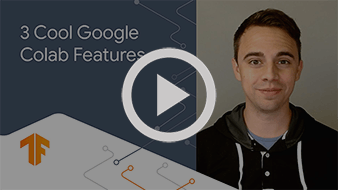
  </a>
</center>

<div class="markdown-google-sans">
  <h2>Qu'est-ce que Colab ?</h2>
</div>

Colab &#40;ou "Colaboratory"&#41; vous permet d'écrire et d'exécuter du code Python dans votre navigateur avec
- Aucune configuration requise
- Accès sans frais aux GPU
- Partage facile

Que vous soyez <strong>étudiant</strong>, <strong>data scientist</strong> ou <strong>chercheur en IA</strong>, Colab peut vous simplifier la tâche. Regardez la <a href="https://www.youtube.com/watch?v=inN8seMm7UI">présentation de Colab</a> pour en savoir plus ou commencez tout de suite.

<div class="markdown-google-sans">

## <strong>Premiers pas</strong>
</div>

Le document que vous consultez n'est pas une page Web statique, mais un environnement interactif appelé <strong>notebook Colab</strong>, qui vous permet d'écrire et d'exécuter du code.

Voici par exemple une <strong>cellule de code</strong> avec un bref script en Python qui calcule une valeur, l'enregistre dans une variable et imprime le résultat :

In [ ]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

Pour exécuter le code dans la cellule ci-dessus, sélectionnez-le en cliquant dessus, puis cliquez sur le bouton de lecture à gauche du code ou utilisez le raccourci clavier Commande/Ctrl+Entrée. Pour modifier le code, cliquez simplement sur la cellule.

Les variables que vous définissez dans une cellule peuvent être utilisées par la suite dans d'autres cellules :

In [ ]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

Les notebooks Colab vous permettent d'utiliser, dans un même document, du <strong>code exécutable</strong>, du <strong>texte enrichi</strong>, des <strong>images</strong>, du code <strong>HTML</strong>, du code <strong>LaTeX</strong> et bien plus. Lorsque vous créez des notebooks Colab, ils sont enregistrés dans votre compte Google Drive. Vous pouvez facilement les partager avec vos collaborateurs ou vos amis, qui peuvent alors y apporter des commentaires ou même les modifier. Pour en savoir plus, consultez la page <a href="/notebooks/basic_features_overview.ipynb">Présentation de Colaboratory</a>. Pour créer un notebook Colab, utilisez le menu "Fichier" ci-dessus ou le lien <a href="http://colab.research.google.com#create=true">Créer un notebook Colab</a>.

Les notebooks Colab sont des notebooks Jupyter hébergés par Colab. Pour en savoir plus sur le projet Jupyter, consultez le site Web <a href="https://www.jupyter.org">jupyter.org</a>.

<div class="markdown-google-sans">

## Science des données
</div>

Colab vous permet de tirer pleinement parti des bibliothèques populaires Python pour analyser et visualiser des données. La cellule de code ci-dessous utilise <strong>numpy</strong> pour générer des données aléatoires et <strong>matplotlib</strong> pour les visualiser. Pour modifier le code, cliquez simplement sur la cellule.

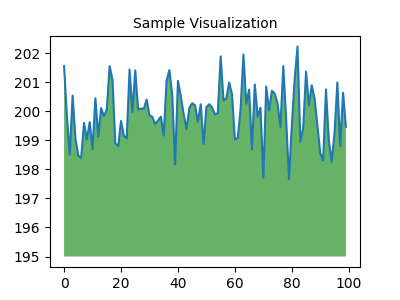

In [ ]:
import numpy as np
import IPython.display as display
from matplotlib import pyplot as plt
import io
import base64

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

fig = plt.figure(figsize=(4, 3), facecolor='w')
plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)
plt.title("Sample Visualization", fontsize=10)

data = io.BytesIO()
plt.savefig(data)
image = F"data:image/png;base64,{base64.b64encode(data.getvalue()).decode()}"
alt = "Sample Visualization"
display.display(display.Markdown(F"""![{alt}]({image})"""))
plt.close(fig)

Vous pouvez importer vos propres données dans les notebooks Colab depuis votre compte Google Drive, y compris depuis des feuilles de calcul, ainsi que depuis GitHub et de nombreuses autres sources. Pour en savoir plus sur l'importation de données et l'utilisation de Colab dans le domaine de la science des données, consultez les liens ci-dessous dans la section <a href="#working-with-data">Utiliser les données</a>.

<div class="markdown-google-sans">

## Machine learning
</div>

Colab vous permet d'importer un ensemble de données d'images, d'entraîner un classificateur d'images sur cet ensemble et d'évaluer le modèle, tout cela avec <a href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb">quelques lignes de code</a>. Les notebooks Colab exécutent ce code sur les serveurs cloud de Google. Vous avez donc à votre disposition toute la puissance du matériel Google, y compris les <a href="#using-accelerated-hardware">GPU et TPU</a>, quelle que soit la puissance de votre ordinateur. Vous n'avez besoin que d'un navigateur.

Colab est très largement utilisé par la communauté du machine learning, par exemple dans les applications suivantes :
- Premiers pas avec TensorFlow
- Développement et entraînement de réseaux de neurones
- Expérimentation avec les TPU
- Dissémination de la recherche en IA
- Création de tutoriels

Pour voir comment les notebooks Colab sont utilisés dans des applications de machine learning, reportez-vous aux <a href="#machine-learning-examples">exemples de machine learning</a> ci-dessous.

<div class="markdown-google-sans">

## Autres ressources

### Utiliser les notebooks dans Colab

</div>

- [Présentation de Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Guide de Markdown](/notebooks/markdown_guide.ipynb)
- [Importer des bibliothèques et installer des dépendances](/notebooks/snippets/importing_libraries.ipynb)
- [Enregistrer et charger des notebooks dans GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Formulaires interactifs](/notebooks/forms.ipynb)
- [Widgets interactifs](/notebooks/widgets.ipynb)

<div class="markdown-google-sans">

<a name="working-with-data"></a>
### Utiliser les données
</div>

- [Chargement de données : Drive, Sheets et Google Cloud Storage](/notebooks/io.ipynb)
- [Graphiques : visualiser les données](/notebooks/charts.ipynb)
- [Premiers pas avec BigQuery](/notebooks/bigquery.ipynb)

<div class="markdown-google-sans">

### Cours d'initiation au Machine Learning

<div>

Vous trouverez ci-dessous quelques-uns des notebooks de la formation Google en ligne sur le machine learning. Consultez la <a href="https://developers.google.com/machine-learning/crash-course/">formation complète en ligne</a> pour en savoir plus.
- [Présentation du DataFrame pandas](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Régression linéaire avec tf.keras et des données synthétiques](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)

<div class="markdown-google-sans">

<a name="using-accelerated-hardware"></a>
### Utiliser le matériel accéléré
</div>

- [TensorFlow avec des GPU](/notebooks/gpu.ipynb)
- [TensorFlow avec des TPU](/notebooks/tpu.ipynb)

<div class="markdown-google-sans">

<a name="machine-learning-examples"></a>

### Exemples

</div>

- <a href="https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/VoiceSwapSample.ipynb">Échange de voix avec NeMo</a> : utilisez le kit Nvidia NeMo pour l'IA conversationnelle afin d'échanger une voix dans un fragment audio contre une voix générée par ordinateur.

- <a href="https://tensorflow.org/hub/tutorials/tf2_image_retraining">Recyclage d'un classificateur d'images</a> : construisez un modèle Keras sur un classificateur d'images pré-entraîné pour faire la distinction entre différentes fleurs.
- <a href="https://tensorflow.org/hub/tutorials/tf2_text_classification">Classification de texte</a> : classez des avis sur des films provenant de la base de données IMDB comme <em>positifs</em> ou <em>négatifs</em>.
- <a href="https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization">Transfert de style</a> : utilisez le deep learning pour transférer un style d'une image à une autre.
- <a href="https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa">Questions/Réponses sur l'encodeur de phrases universel multilingue</a> : utilisez un modèle de machine learning afin de répondre aux questions issues de l'ensemble de données SQuAD.
- <a href="https://tensorflow.org/hub/tutorials/tweening_conv3d">Interpolation vidéo</a> : prédisez ce qui s'est passé entre la première et la dernière image d'une vidéo.
